# **Preprocessing**

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv(r'netflix.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [ ]:
df.rename(columns={"director": "Director", "country": "Country", "cast":"Cast", "date_added":"Date_Added","rating":"Rating",
                   "duration":"Duration","show_id":"Show_ID","type":"Video_Type","title":"Title", "release_year":"Year_Release","listed_in":"Genres","description":"Description"}, inplace=True)
df.columns

Index(['Show_ID', 'Video_Type', 'Title', 'Director', 'Cast', 'Country',
       'Date_Added', 'Year_Release', 'Rating', 'Duration', 'Genres',
       'Description'],
      dtype='object')

In [ ]:
duration_dict = {
    's5542': '74 min',
    's5795': '84 min',
    's5814': '66 min'
}

df['Duration'] = df['Show_ID'].map(duration_dict).fillna(df['Duration'])

df.isna().sum()

Show_ID            0
Video_Type         0
Title              0
Director        2634
Cast             825
Country          831
Date_Added        10
Year_Release       0
Rating             4
Duration           0
Genres             0
Description        0
dtype: int64

In [ ]:
rating_dict = {
    's5542': 'TV-MA',
    's5795': 'TV-MA',
    's5814': 'TV-MA',
    's5990': 'TV-PG',
    's6828': 'TV-14',
    's7313': 'TV-G',
    's7538': 'PG-13'
}

df['Rating'] = df['Show_ID'].map(rating_dict).fillna(df['Rating'])

df.isna().sum()

Show_ID            0
Video_Type         0
Title              0
Director        2634
Cast             825
Country          831
Date_Added        10
Year_Release       0
Rating             0
Duration           0
Genres             0
Description        0
dtype: int64

In [ ]:
# Fill missing Date_Added with January 1st of Year_Release in the format '%B %d, %Y'
df['Date_Added'] = df.apply(
    lambda row: pd.Timestamp(f"{int(row['Year_Release'])}-01-01").strftime('%B %d, %Y') if pd.isna(row['Date_Added']) else pd.Timestamp(row['Date_Added']).strftime('%B %d, %Y'),
    axis=1
)

In [ ]:
# Fill missing values in 'Director', 'Cast', and 'Country' with 'Unknown'
df.fillna({'Director': 'Unknown', 'Cast': 'Unknown', 'Country': 'Unknown'}, inplace=True)

In [ ]:
df.isnull().sum()

Show_ID         0
Video_Type      0
Title           0
Director        0
Cast            0
Country         0
Date_Added      0
Year_Release    0
Rating          0
Duration        0
Genres          0
Description     0
dtype: int64

In [ ]:
df.shape

(8807, 12)

In [ ]:
# Calculate IQR
Q1 = df['Year_Release'].quantile(0.25)
Q3 = df['Year_Release'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the number and percentage of outliers
outliers = df[(df['Year_Release'] < lower_bound) | (df['Year_Release'] > upper_bound)]
num_outliers = outliers.shape[0]
total_data_points = df.shape[0]
percent_outliers = (num_outliers / total_data_points) * 100
print(f'Percentage of outliers in Year_Release: {percent_outliers:.2f}%')

Percentage of outliers in Year_Release: 8.16%


In [ ]:
df_no_outliers = df[(df['Year_Release'] >= lower_bound) & (df['Year_Release'] <= upper_bound)]

print(f'Skewness of Year Release after handling outliers is {df_no_outliers.Year_Release.skew()}')

Skewness of Year Release after handling outliers is -1.193808762029756


In [ ]:
df['Date_Added'] = df['Date_Added'].str.strip()
df['Date_Added'] = pd.to_datetime(df['Date_Added'])

In [ ]:
processed_df = df.copy()
movie_df = df[df['Video_Type'] == 'Movie']
tv_show_df = df[df['Video_Type'] == 'TV Show']

# **Latent Dirichlet Allocation (LDA)**

## Processing for Description

In [ ]:
processed_df['Description']

0       As her father nears the end of his life, filmm...
1       After crossing paths at a party, a Cape Town t...
2       To protect his family from a powerful drug lor...
3       Feuds, flirtations and toilet talk go down amo...
4       In a city of coaching centers known to train I...
                              ...                        
8802    A political cartoonist, a crime reporter and a...
8803    While living alone in a spooky town, a young g...
8804    Looking to survive in a world taken over by zo...
8805    Dragged from civilian life, a former superhero...
8806    A scrappy but poor boy worms his way into a ty...
Name: Description, Length: 8088, dtype: object

In [ ]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
import nltk

# Step 1: Case Lowering
processed_df = df.copy()
processed_df['Lowered_Description'] = processed_df['Description'].str.lower()
print("After Case Lowering:")
print(processed_df['Lowered_Description'])

After Case Lowering:
0       as her father nears the end of his life, filmm...
1       after crossing paths at a party, a cape town t...
2       to protect his family from a powerful drug lor...
3       feuds, flirtations and toilet talk go down amo...
4       in a city of coaching centers known to train i...
                              ...                        
8802    a political cartoonist, a crime reporter and a...
8803    while living alone in a spooky town, a young g...
8804    looking to survive in a world taken over by zo...
8805    dragged from civilian life, a former superhero...
8806    a scrappy but poor boy worms his way into a ty...
Name: Lowered_Description, Length: 8088, dtype: object


Converting all the text to lowercase to ensure uniformity.

In [ ]:
# Step 2: Removing Stop Words & Tokenization
import nltk
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

processed_df['No_Stop_Words_Description'] = processed_df['Lowered_Description'].apply(remove_stop_words)
print("\nAfter Removing Stop Words:")
print(processed_df['No_Stop_Words_Description'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



After Removing Stop Words:
0       father nears end life filmmaker kirsten johnso...
1       crossing paths party cape town teen sets prove...
2       protect family powerful drug lord skilled thie...
3       feuds flirtations toilet talk go among incarce...
4       city coaching centers known train india finest...
                              ...                        
8802    political cartoonist crime reporter pair cops ...
8803    living alone spooky town young girl befriends ...
8804    looking survive world taken zombies dorky coll...
8805    dragged civilian life former superhero must tr...
8806    scrappy poor boy worms way tycoon dysfunctiona...
Name: No_Stop_Words_Description, Length: 8088, dtype: object


Splitting text into individual units, such as words or phrases, called tokens.  
Removing common words (like "and", "the", "is") that do not contribute significant meaning to the analysis.

In [ ]:
# Step 3: Lemmatizing
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(tokens)

processed_df['Lemmatized_Description'] = processed_df['No_Stop_Words_Description'].apply(lemmatize)
print("\nAfter Lemmatizing:")
print(processed_df['Lemmatized_Description'])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



After Lemmatizing:
0       father nears end life filmmaker kirsten johnso...
1       cross path party cape town teen set prove whet...
2       protect family powerful drug lord skilled thie...
3       feuds flirtation toilet talk go among incarcer...
4       city coaching center know train india fine col...
                              ...                        
8802    political cartoonist crime reporter pair cop i...
8803    live alone spooky town young girl befriend mot...
8804    look survive world take zombie dorky college s...
8805    drag civilian life former superhero must train...
8806    scrappy poor boy worm way tycoon dysfunctional...
Name: Lemmatized_Description, Length: 8088, dtype: object


Reducing words to their base or root form (lemma). For instance, "living" becomes "live"

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 4: Vectorizing
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed_df['Lemmatized_Description'])

print("\nAfter Vectorizing (TF-IDF):")
print(X.toarray())


After Vectorizing (TF-IDF):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Converting text into numerical vectors that can be processed by machine learning algorithms.

In [ ]:
print("Shape of the TF-IDF matrix:", X.shape)

feature_names = vectorizer.get_feature_names_out()
print("\nFeature names (first 10):", feature_names[:10])

Shape of the TF-IDF matrix: (8088, 14869)

Feature names (first 10): ['007' '009' '10' '100' '10th' '11' '12' '12th' '13' '14']


In [ ]:
import numpy as np

tfidf_array = X.toarray()
max_tfidf_values = np.max(tfidf_array, axis=0)
feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame({
    'Feature': feature_names,
    'Max_TFIDF_Value': max_tfidf_values
})

sorted_tfidf_df = tfidf_df.sort_values(by='Max_TFIDF_Value', ascending=False)

# Top features with the highest TF-IDF values
top_n = 10
print(f"\nTop {top_n} features with the highest TF-IDF values:")
print(sorted_tfidf_df.head(top_n))


Top 10 features with the highest TF-IDF values:
       Feature  Max_TFIDF_Value
12817    sugar         0.739205
9731    parker         0.691282
7819     llama         0.685840
499       ajin         0.685098
8144   manisha         0.681445
2059       bye         0.678885
179         50         0.669046
2457   chicago         0.666991
732    angelus         0.664061
8181    marcus         0.659439


In [ ]:
processed_df['Processed_Description'] = processed_df['Lemmatized_Description']

## Topic Modelling

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lda', LatentDirichletAllocation(random_state=42))
])

# Define the parameter grid
param_grid = {
    'tfidf__max_features': [500, 1000, 2000],
    'lda__n_components': [3, 5, 7]
}


In [ ]:
from sklearn.model_selection import GridSearchCV

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid_search.fit(processed_df['Processed_Description'])

# Best Model
best_model = grid_search.best_estimator_

# Print the best parameters and scores
print("Best Model's Params: ", grid_search.best_params_)
print("Best Log Likelihood Score: ", grid_search.best_score_)
print("Model Perplexity: ", best_model.named_steps['lda'].perplexity(grid_search.best_estimator_.named_steps['tfidf'].transform(processed_df['Processed_Description'])))

Best Model's Params:  {'lda__n_components': 3, 'tfidf__max_features': 500}
Best Log Likelihood Score:  -28069.795642788016
Model Perplexity:  678.5635348328899


In [ ]:
# Extract the best LDA model and vectorizer
best_lda_model = best_model.named_steps['lda']
best_vectorizer = best_model.named_steps['tfidf']

# Transform the data using the best vectorizer
X_transformed = best_vectorizer.transform(processed_df['Processed_Description'])

In [ ]:
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

processed_df['Tokenized_Description'] = processed_df['Processed_Description'].apply(lambda x: x.split() if isinstance(x, str) else x)

dictionary = corpora.Dictionary(processed_df['Tokenized_Description'])
corpus = [dictionary.doc2bow(text) for text in processed_df['Tokenized_Description']]

# Convert the LDA model to gensim format
gensim_lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=best_lda_model.n_components,
    passes=10,
    alpha='auto',
    eta='auto',
    random_state=43
)

# Calculate the coherence score
coherence_model_lda = CoherenceModel(model=gensim_lda_model, texts=processed_df['Tokenized_Description'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()

print("Coherence Score: ", coherence_score)

Coherence Score:  0.4121178624446446


In [ ]:
# Function to display topics
def display_topics(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-n_top_words - 1:-1]}
        topics.append(topic_words)
    return topics

In [ ]:
n_top_words = 50
tf_feature_names = best_vectorizer.get_feature_names_out()
topics = display_topics(best_lda_model, tf_feature_names, n_top_words)

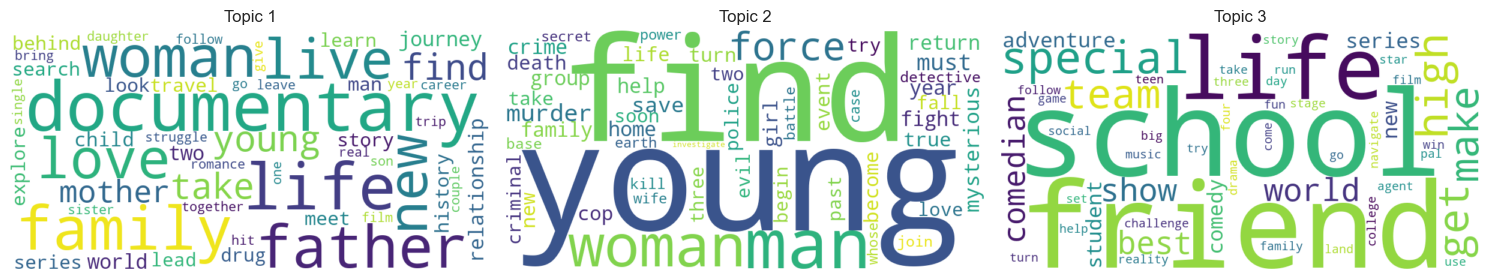

In [ ]:
# Plot the word clouds for each topic
fig, axes = plt.subplots(1, len(topics), figsize=(15, 5), sharex=True, sharey=True)

for i, topic in enumerate(topics):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Topic {i+1}')

plt.tight_layout()
plt.show()

In [ ]:
import pyLDAvis
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(best_lda_model, X_transformed, best_vectorizer, mds='tsne')
pyLDAvis.display(panel)

This visualization can be found on streamlit at https://app-ldavisualization-hyajjpblvw3gnl8xhzz3p4.streamlit.app

In [ ]:
# Get the topic distribution for each document
doc_topic_distributions = best_lda_model.transform(X_transformed)

print("Topic distribution for the documents:")
print(doc_topic_distributions)

Topic distribution for the documents:
[[0.52884574 0.17328145 0.29787281]
 [0.61458589 0.28411077 0.10130334]
 [0.22620206 0.68667862 0.08711931]
 ...
 [0.21418205 0.09402064 0.69179731]
 [0.10976734 0.77355254 0.11668013]
 [0.12123806 0.60597546 0.27278647]]


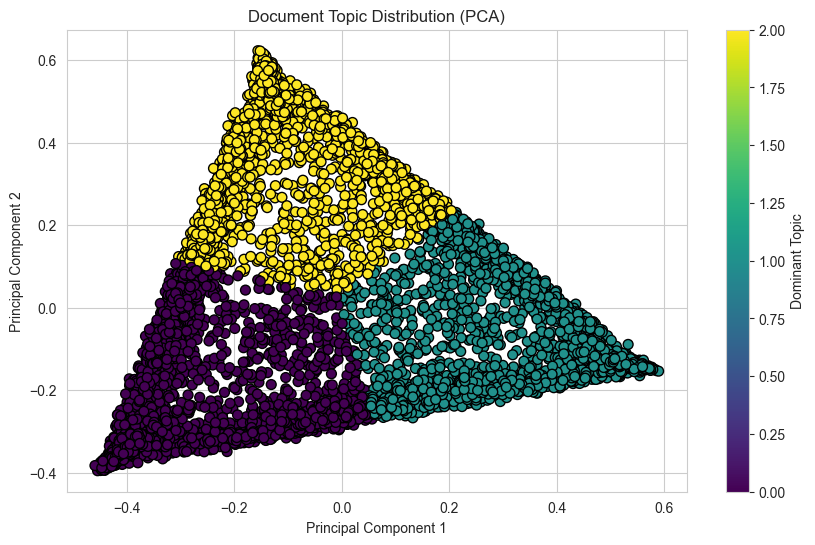

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Determine the dominant topic for each document
dominant_topic = np.argmax(doc_topic_distributions, axis=1)

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
doc_topic_pca = pca.fit_transform(doc_topic_distributions)

# Scatter plot using PCA with coloring based on dominant topic
plt.figure(figsize=(10, 6))
scatter = plt.scatter(doc_topic_pca[:, 0], doc_topic_pca[:, 1], c=dominant_topic, cmap='viridis', edgecolor='k', s=50)
plt.title('Document Topic Distribution (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Dominant Topic')
plt.grid(True)
plt.show()

The PCA object is instantiated with n_components=2 so that the data will be reduced to two principal components to allow us to fit the PCA model to the data and transform it into the new 2-dimensional space.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import ternary

# Normalize the topic distributions to sum to 1
doc_topic_distributions = doc_topic_distributions / doc_topic_distributions.sum(axis=1, keepdims=True)


data = doc_topic_distributions[:, :3]
dominant_topic = np.argmax(doc_topic_distributions, axis=1)

figure, tax = ternary.figure(scale=1.0)
tax.boundary(linewidth=2.0)
tax.gridlines(multiple=0.1, color="blue")

cmap = plt.get_cmap('viridis')
colors = cmap(dominant_topic / dominant_topic.max())

for i, point in enumerate(data):
    tax.scatter([point], marker='o', color=colors[i], label=f'Document {i+1}' if i == 0 else "")

tax.left_axis_label("Topic 1", fontsize=12)
tax.right_axis_label("Topic 2", fontsize=12)
tax.bottom_axis_label("Topic 3", fontsize=12)

tax.set_title("Ternary Plot of Document Topic Distributions")
tax.legend()

plt.show()

Plot that represents the proportions of three variables that sum to a constant.

- Ternary Plot: Visualizes the proportions of three topics for each document, with each point representing a combination of the three topics that sum to 1.
- PCA Plot: Reduces the dimensionality of the data to 2D or 3D, with each point representing the document's projection onto the principal components, capturing the most variance in the data.

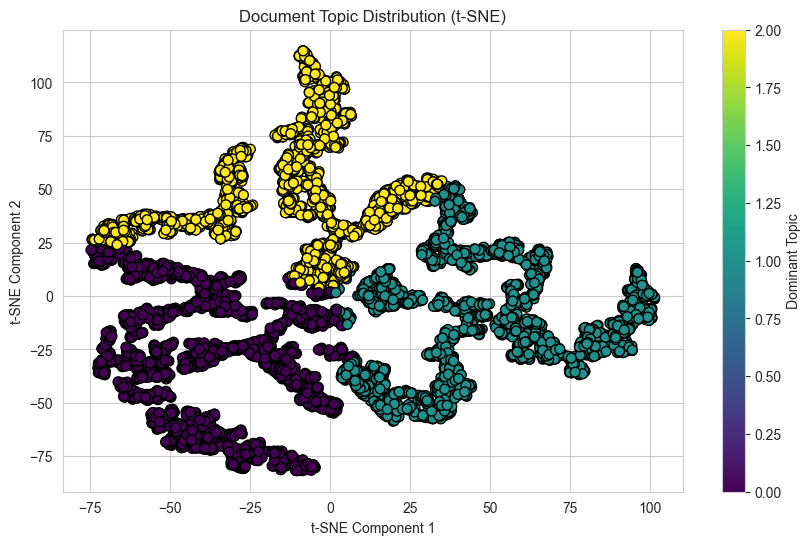

In [ ]:
# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
doc_topic_tsne = tsne.fit_transform(doc_topic_distributions)

cmap = plt.get_cmap('viridis')
colors = cmap(dominant_topic / dominant_topic.max())

plt.figure(figsize=(10, 6))
scatter = plt.scatter(doc_topic_tsne[:, 0], doc_topic_tsne[:, 1], c=dominant_topic, cmap='viridis', edgecolor='k', s=50)
plt.title('Document Topic Distribution (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Dominant Topic')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate
import numpy as np

# Compute the cosine similarity between documents based on their topic distributions
similarity_matrix = cosine_similarity(doc_topic_distributions)

similar_docs = similarity_matrix[0].argsort()[::-1][1:6]  # Top 5 similar documents

print("Description of the first document:")
print(processed_df['Description'][0])
print("\nTop 5 similar documents to the first document:")

table_data = []

for idx in similar_docs:
    table_data.append([idx, processed_df['Description'][idx], f"{similarity_matrix[0][idx]:.4f}", f"Topic {np.argmax(doc_topic_distributions[idx]) + 1}"])

headers = ["Document Index", "Description", "Cosine Similarity", "Dominant Topic"]

print(tabulate(table_data, headers=headers, tablefmt="grid"))

Description of the first document:
As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.

Top 5 similar documents to the first document:
+------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+------------------+
|   Document Index | Description                                                                                                                                             |   Cosine Similarity | Dominant Topic   |
+==================+=========================================================================================================================================================+=====================+==================+
|             3844 | When a busy mother and father realize they need help with their two young children, they hire a

# **Hierachical Clustering**

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

In [ ]:
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /home/xkchok/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/xkchok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Function for preprocessing text
def preprocess_text(text):
    # Step 1: Case lowering
    text = text.lower()
    # Step 2: Tokenization
    tokens = word_tokenize(text)
    # Step 3: Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in string.punctuation]
    return ' '.join(tokens)

In [ ]:
# Apply preprocessing to the 'Description' column
df['Processed_Description'] = df['Description'].apply(preprocess_text)

In [ ]:
print(df['Processed_Description'])

0       a her father nears the end of his life filmmak...
1       after crossing path at a party a cape town tee...
2       to protect his family from a powerful drug lor...
3       feud flirtation and toilet talk go down among ...
4       in a city of coaching center known to train in...
                              ...                        
8802    a political cartoonist a crime reporter and a ...
8803    while living alone in a spooky town a young gi...
8804    looking to survive in a world taken over by zo...
8805    dragged from civilian life a former superhero ...
8806    a scrappy but poor boy worm his way into a tyc...
Name: Processed_Description, Length: 8807, dtype: object


In [ ]:
# Step 4: Preprocess the text data
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Processed_Description'])

In [ ]:
from sklearn.metrics.pairwise import cosine_distances

# Compute the cosine distance matrix
distance_matrix = cosine_distances(X)

/tmp/ipykernel_159607/1276388505.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


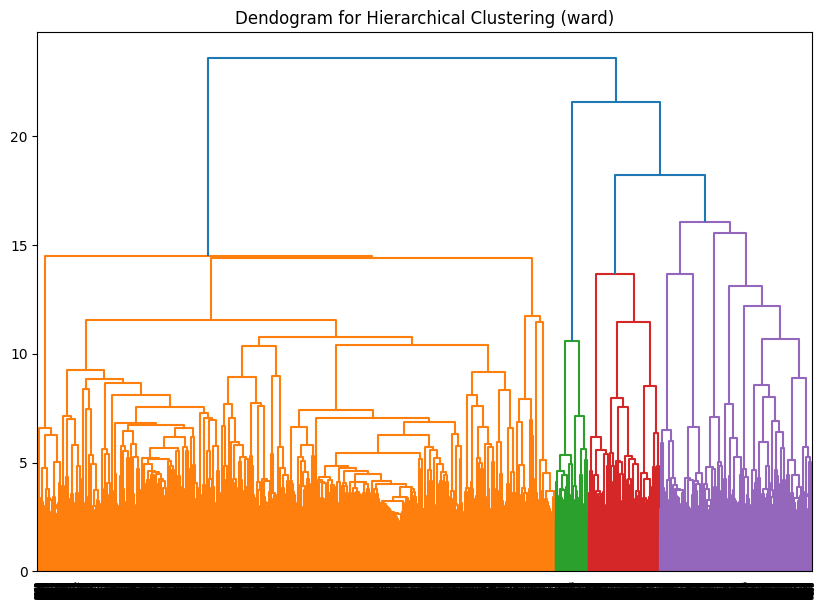

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform hierarchical/agglomerative clustering
Z = linkage(distance_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Dendogram for Hierarchical Clustering (ward)')
dendrogram(Z)
plt.show()

n_clusters = 4

In [ ]:
# Fit the clustering model with 4 clusters
n_clusters = 4
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df['Cluster'] = clustering.fit_predict(X.toarray())

In [ ]:
df.Cluster.value_counts()

Cluster
0    6441
1    1725
3     325
2     316
Name: count, dtype: int64

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Dimensionality Reduction using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

In [ ]:
# Dimensionality Reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

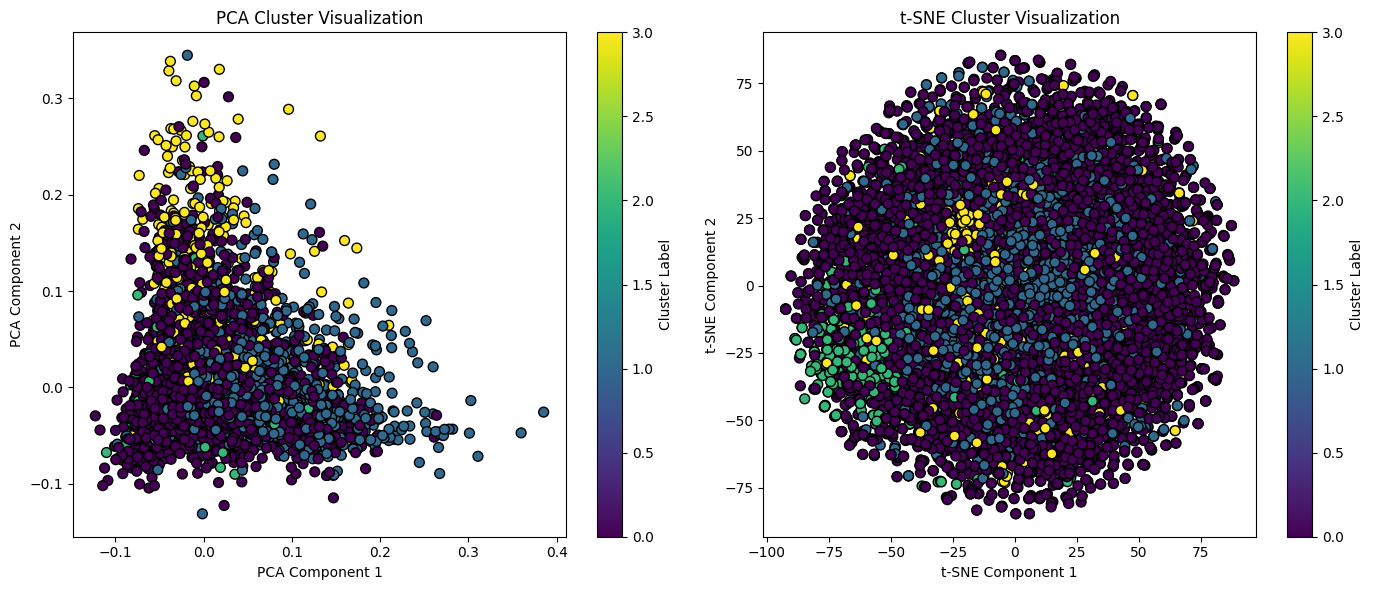

In [ ]:
# Plotting PCA
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('PCA Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')

# Plotting t-SNE
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('t-SNE Cluster Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')

plt.tight_layout()
plt.show()


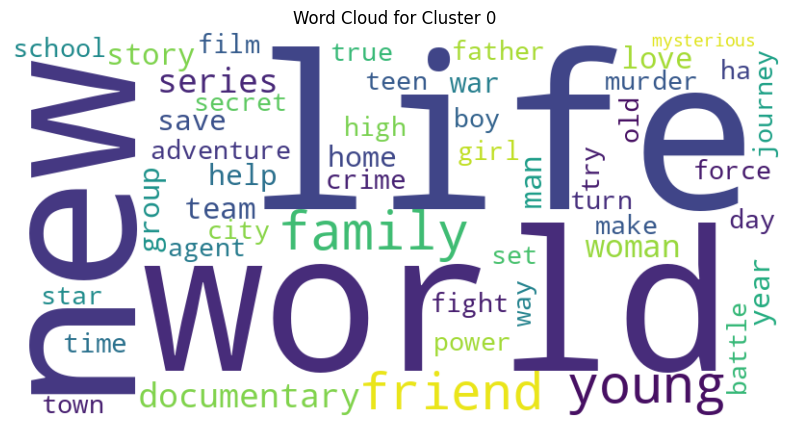

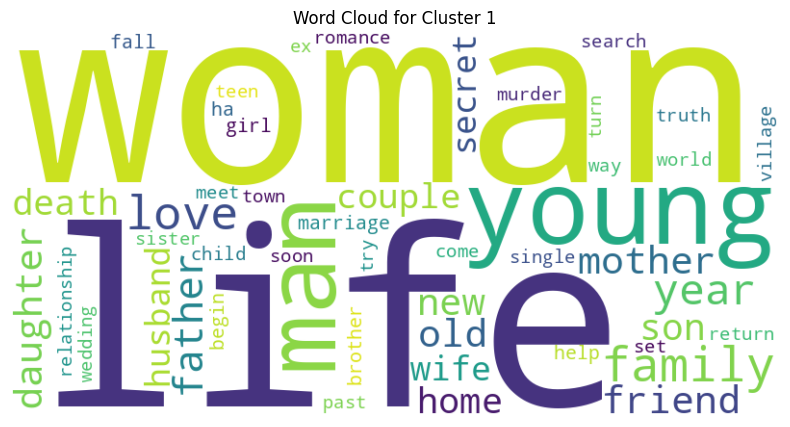

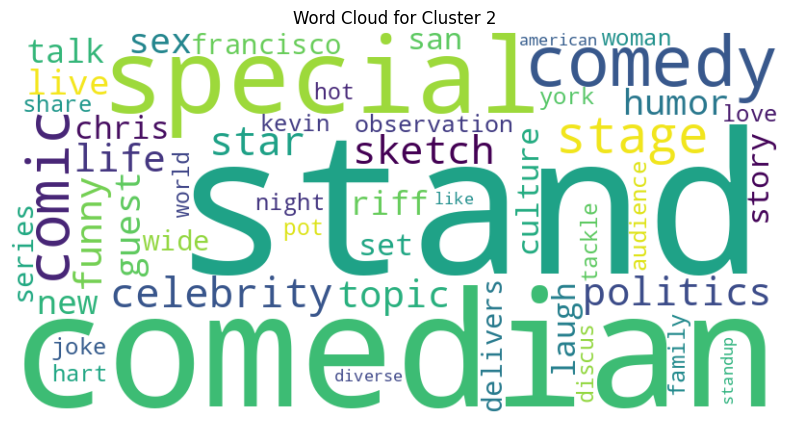

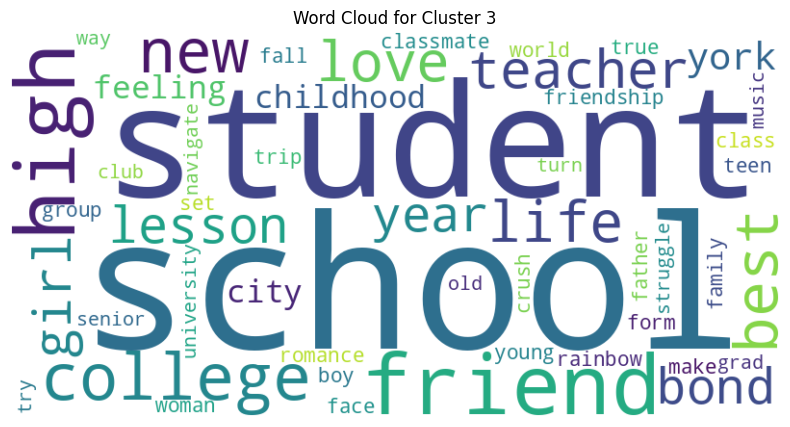

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create a DataFrame for the TF-IDF scores
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Visualize the most important words in each cluster
for cluster in range(n_clusters):
    # Get the indices of the documents in the current cluster
    cluster_indices = df[df['Cluster'] == cluster].index
    
    # Sum the TF-IDF scores for the words in the current cluster
    cluster_tfidf = tfidf_df.iloc[cluster_indices].sum(axis=0)
    
    # Convert to a DataFrame for easier manipulation
    cluster_tfidf_df = pd.DataFrame(cluster_tfidf, columns=['TF-IDF']).reset_index()
    cluster_tfidf_df.columns = ['Word', 'TF-IDF']
    
    # Sort by TF-IDF score
    cluster_tfidf_df = cluster_tfidf_df.sort_values(by='TF-IDF', ascending=False).head(50)  # Top 10 words
    
    # Create a word cloud
    plt.figure(figsize=(10, 5))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(cluster_tfidf_df['Word'], cluster_tfidf_df['TF-IDF'])))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.show()


n_clusters = 3

In [ ]:
# Fit the clustering model with 4 clusters
n_clusters = 3
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df['Cluster'] = clustering.fit_predict(X.toarray())

In [ ]:
df.Cluster.value_counts()

Cluster
1    5939
0    2537
2     331
Name: count, dtype: int64

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

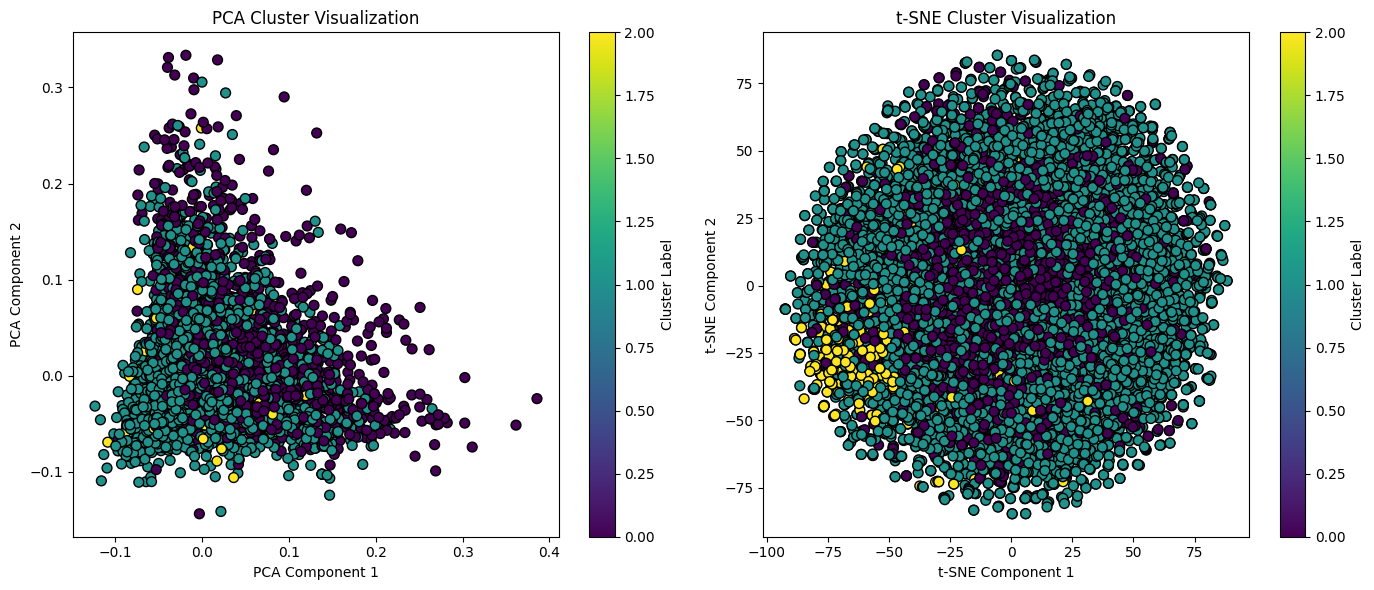

In [ ]:
# Plotting PCA
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('PCA Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')

# Plotting t-SNE
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('t-SNE Cluster Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')

plt.tight_layout()
plt.show()

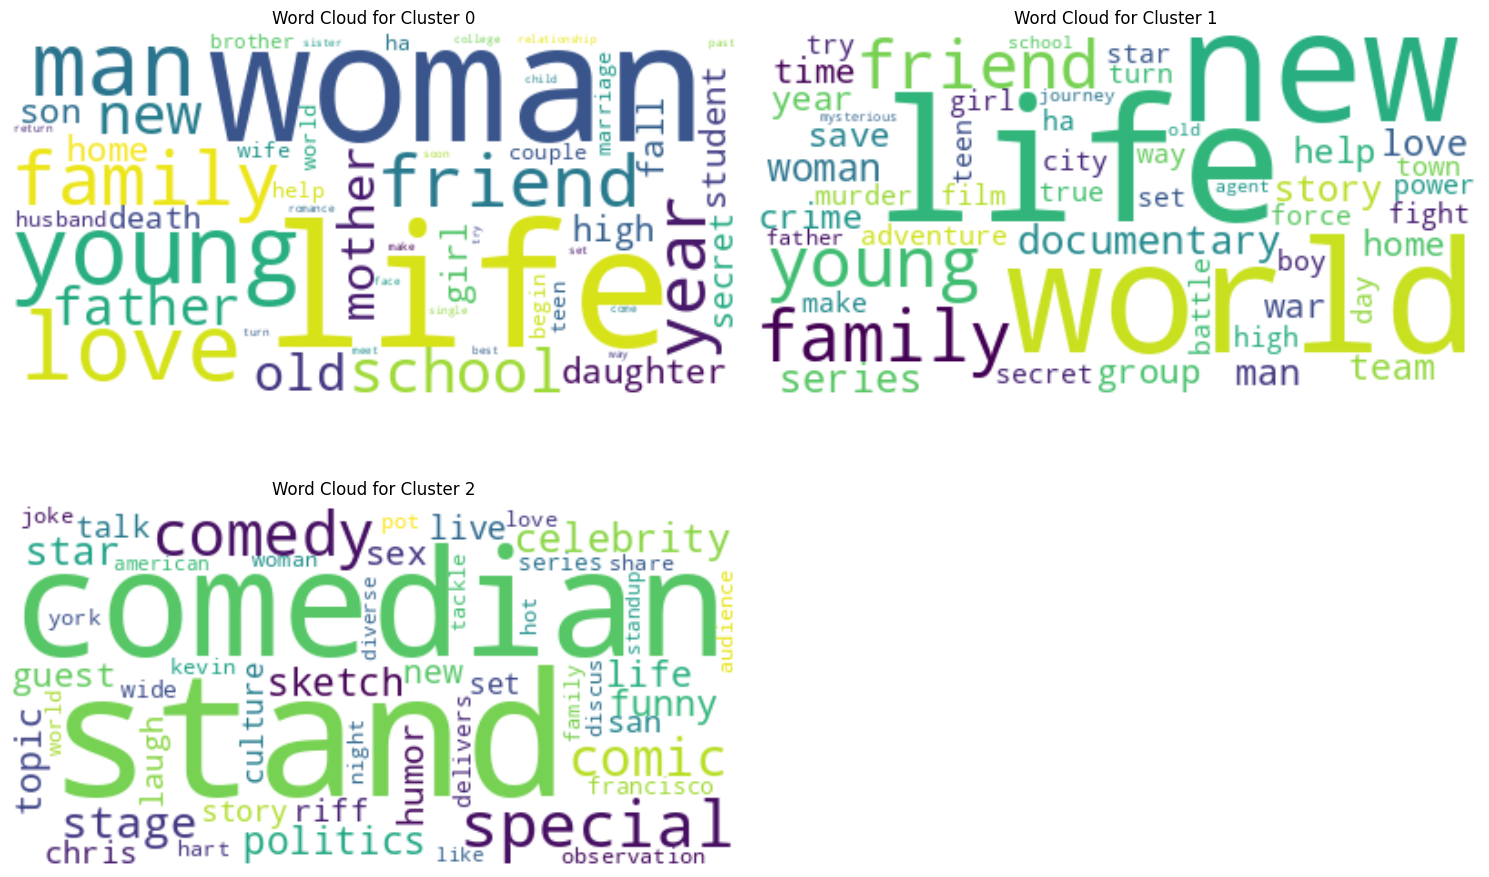

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create a DataFrame for the TF-IDF scores
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Set up the plot for word clouds
plt.figure(figsize=(15, 10))

# Visualize the most important words in each cluster
for cluster in range(n_clusters):
    # Get the indices of the documents in the current cluster
    cluster_indices = df[df['Cluster'] == cluster].index
    
    # Sum the TF-IDF scores for the words in the current cluster
    cluster_tfidf = tfidf_df.iloc[cluster_indices].sum(axis=0)
    
    # Convert to a DataFrame for easier manipulation
    cluster_tfidf_df = pd.DataFrame(cluster_tfidf, columns=['TF-IDF']).reset_index()
    cluster_tfidf_df.columns = ['Word', 'TF-IDF']
    
    # Sort by TF-IDF score
    cluster_tfidf_df = cluster_tfidf_df.sort_values(by='TF-IDF', ascending=False).head(50)  # Top 10 words
    
    # Create a word cloud
    plt.subplot(2, 2, cluster + 1)  # Adjust the layout for 4 clusters
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(dict(zip(cluster_tfidf_df['Word'], cluster_tfidf_df['TF-IDF'])))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')

plt.tight_layout()
plt.show()


n_clusters = 5

In [ ]:
# Fit the clustering model with 4 clusters
n_clusters = 5
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df['Cluster'] = clustering.fit_predict(X.toarray())

In [ ]:
df.Cluster.value_counts()

Cluster
0    5228
4    2114
1     711
3     423
2     331
Name: count, dtype: int64

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

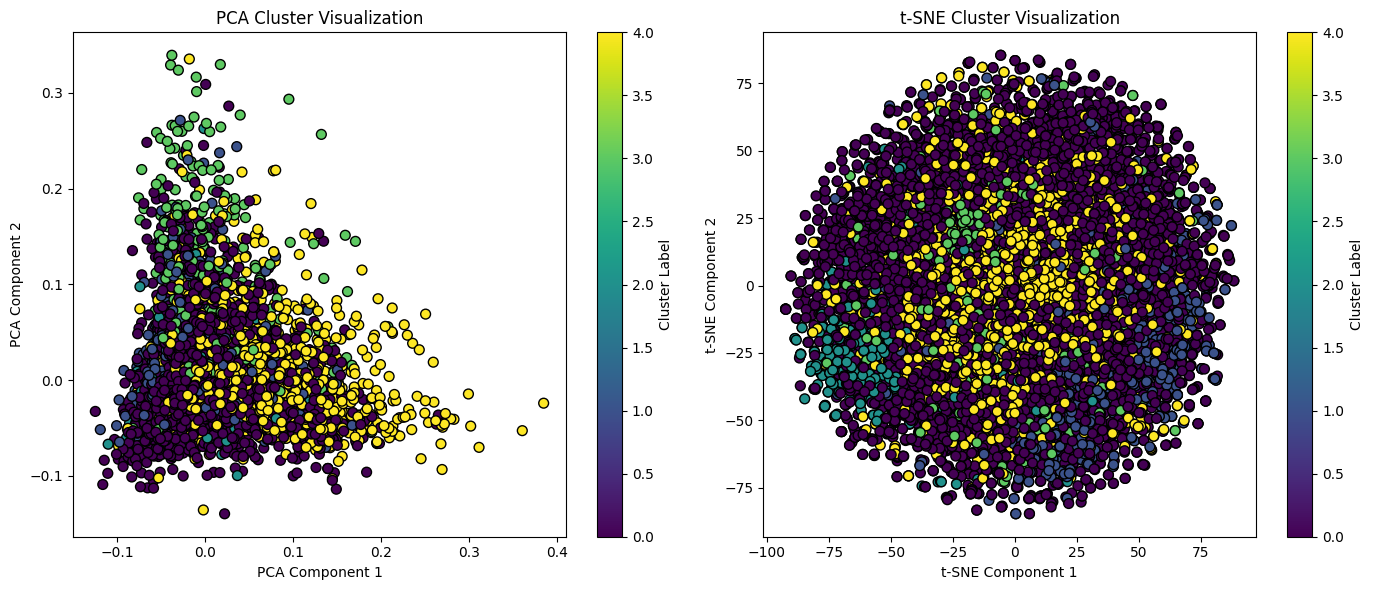

In [ ]:
# Plotting PCA
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('PCA Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')

# Plotting t-SNE
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('t-SNE Cluster Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')

plt.tight_layout()
plt.show()

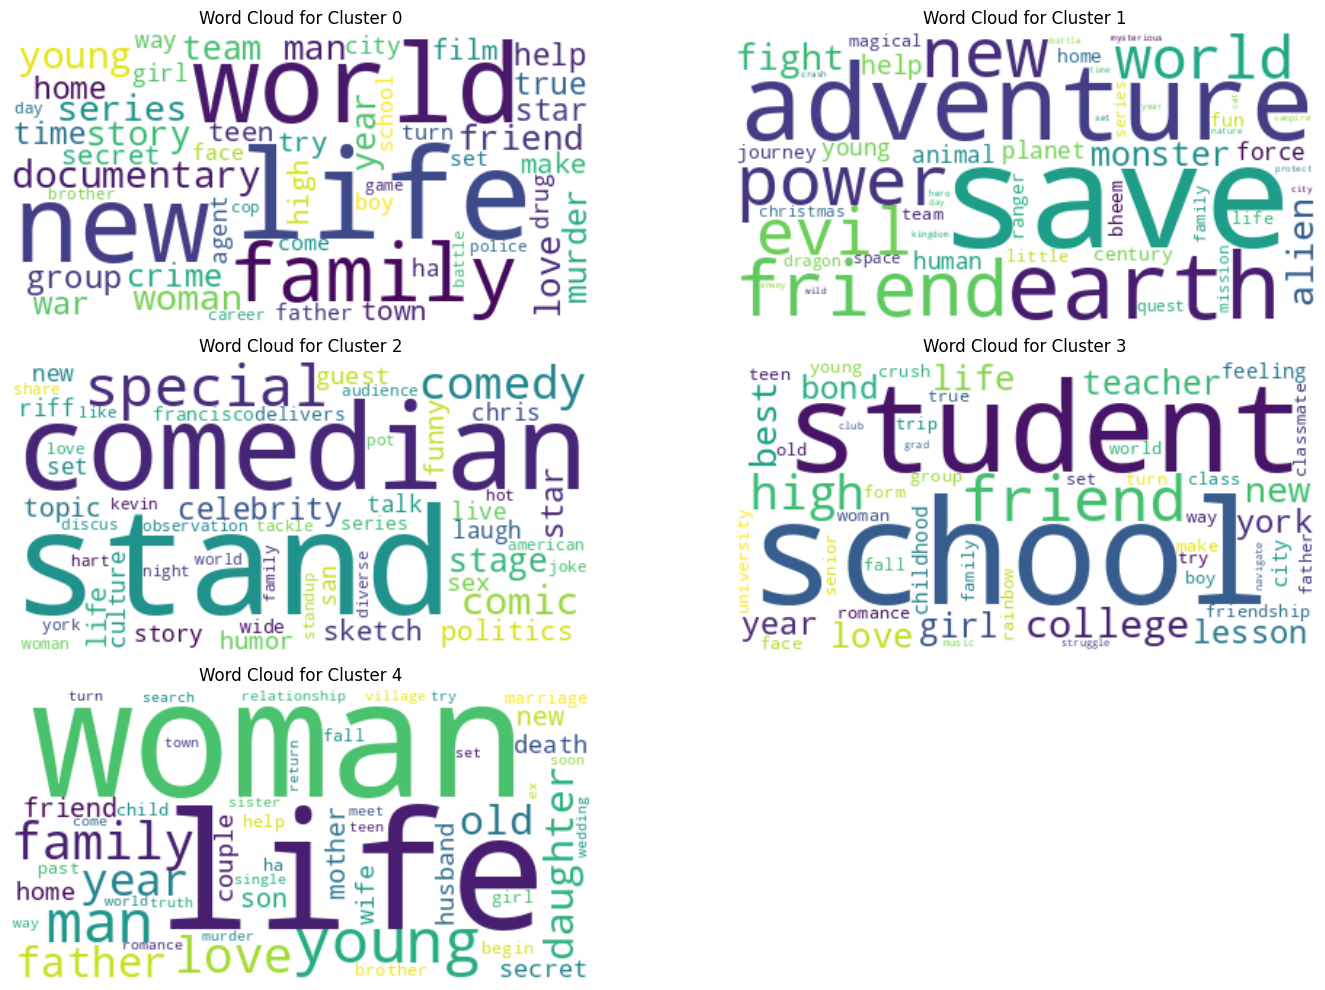

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create a DataFrame for the TF-IDF scores
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Set up the plot for word clouds
plt.figure(figsize=(15, 10))

# Visualize the most important words in each cluster
for cluster in range(n_clusters):
    # Get the indices of the documents in the current cluster
    cluster_indices = df[df['Cluster'] == cluster].index
    
    # Sum the TF-IDF scores for the words in the current cluster
    cluster_tfidf = tfidf_df.iloc[cluster_indices].sum(axis=0)
    
    # Convert to a DataFrame for easier manipulation
    cluster_tfidf_df = pd.DataFrame(cluster_tfidf, columns=['TF-IDF']).reset_index()
    cluster_tfidf_df.columns = ['Word', 'TF-IDF']
    
    # Sort by TF-IDF score
    cluster_tfidf_df = cluster_tfidf_df.sort_values(by='TF-IDF', ascending=False).head(50)  # Top 10 words
    
    # Create a word cloud
    plt.subplot(3, 2, cluster + 1)  # Adjust the layout for 4 clusters
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(dict(zip(cluster_tfidf_df['Word'], cluster_tfidf_df['TF-IDF'])))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')

plt.tight_layout()
plt.show()


In [ ]:
# Basic cluster characteristics
print("Cluster sizes:")
print(df['Cluster'].value_counts())

# For each cluster, analyze:
for cluster in sorted(df['Cluster'].unique()):
    print(f"\nCluster {cluster} characteristics:\n")
    
    # Video Type distribution
    print("Video Type distribution:")
    type_dist = df[df['Cluster'] == cluster]['Video_Type'].value_counts(normalize=True)
    print(type_dist)
    
    # Top 5 genres
    print("\nTop 5 genres:")
    genres = df[df['Cluster'] == cluster]['Genres'].str.split(',').explode().str.strip()
    print(genres.value_counts().head())
    
    # Top 5 countries
    print("\nTop 5 countries:")
    countries = df[df['Cluster'] == cluster]['Country'].str.split(',').explode().str.strip()
    print(countries.value_counts().head())
    
    # Average release year
    print("\nAverage release year:", df[df['Cluster'] == cluster]['Year_Release'].mean())

Cluster sizes:
Cluster
0    5228
4    2114
1     711
3     423
2     331
Name: count, dtype: int64

Cluster 0 characteristics:

Video Type distribution:
Video_Type
Movie      0.693382
TV Show    0.306618
Name: proportion, dtype: float64

Top 5 genres:
Genres
International Movies      1586
Dramas                    1355
Comedies                   934
International TV Shows     804
Documentaries              705
Name: count, dtype: int64

Top 5 countries:
Country
United States     2298
India              564
United Kingdom     530
Unknown            471
Canada             269
Name: count, dtype: int64

Average release year: 2014.023335883703

Cluster 1 characteristics:

Video Type distribution:
Video_Type
Movie      0.594937
TV Show    0.405063
Name: proportion, dtype: float64

Top 5 genres:
Genres
Children & Family Movies    187
Kids' TV                    154
International Movies        110
Action & Adventure          102
Comedies                    101
Name: count, dtype: int64

Top 5

n_clusters = 6

In [ ]:
# Fit the clustering model with 4 clusters
n_clusters = 6
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df['Cluster'] = clustering.fit_predict(X.toarray())

In [ ]:
df.Cluster.value_counts()

Cluster
0    5162
4    2114
1     711
3     423
5     331
2      66
Name: count, dtype: int64

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

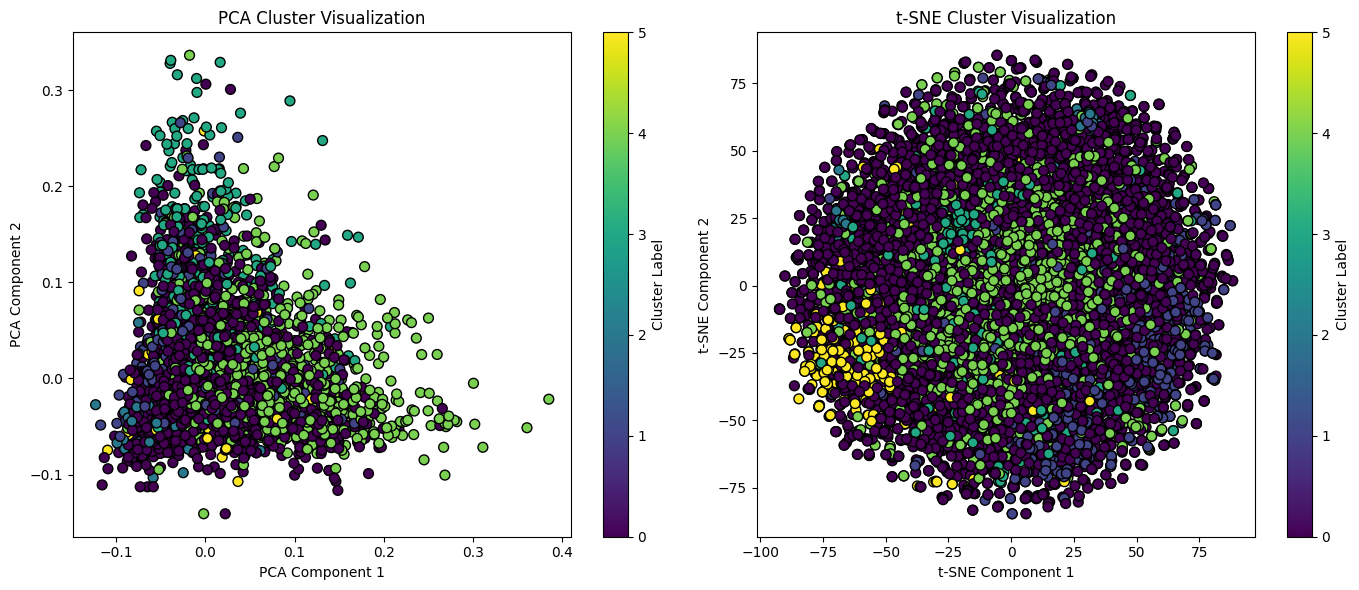

In [ ]:
# Plotting PCA
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('PCA Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')

# Plotting t-SNE
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('t-SNE Cluster Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')

plt.tight_layout()
plt.show()

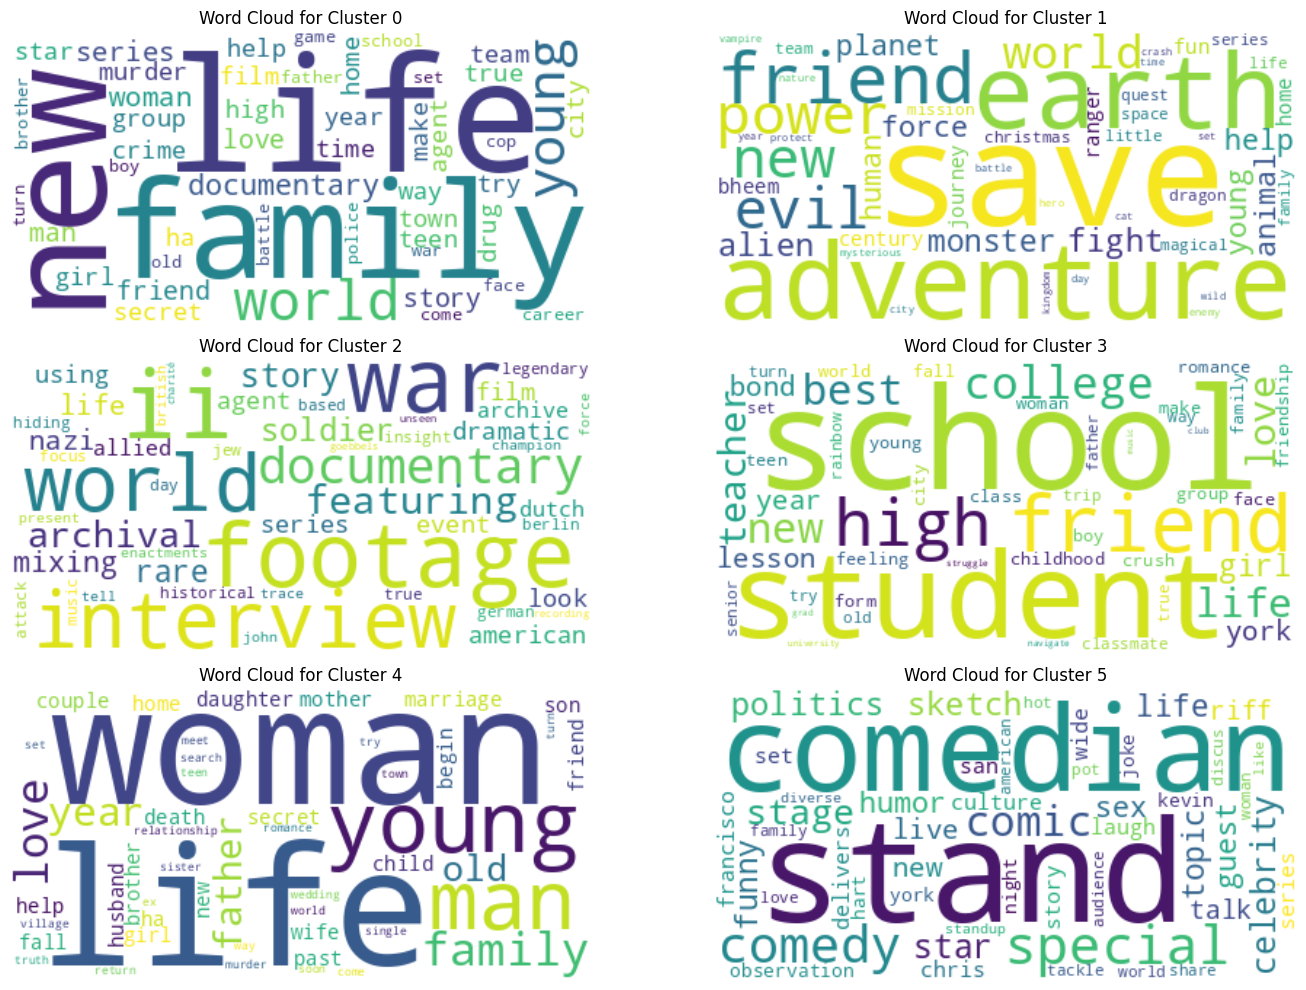

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create a DataFrame for the TF-IDF scores
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Set up the plot for word clouds
plt.figure(figsize=(15, 10))

# Visualize the most important words in each cluster
for cluster in range(n_clusters):
    # Get the indices of the documents in the current cluster
    cluster_indices = df[df['Cluster'] == cluster].index
    
    # Sum the TF-IDF scores for the words in the current cluster
    cluster_tfidf = tfidf_df.iloc[cluster_indices].sum(axis=0)
    
    # Convert to a DataFrame for easier manipulation
    cluster_tfidf_df = pd.DataFrame(cluster_tfidf, columns=['TF-IDF']).reset_index()
    cluster_tfidf_df.columns = ['Word', 'TF-IDF']
    
    # Sort by TF-IDF score
    cluster_tfidf_df = cluster_tfidf_df.sort_values(by='TF-IDF', ascending=False).head(50)  # Top 10 words
    
    # Create a word cloud
    plt.subplot(3, 2, cluster + 1)  # Adjust the layout for 4 clusters
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(dict(zip(cluster_tfidf_df['Word'], cluster_tfidf_df['TF-IDF'])))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, pairwise_distances
import matplotlib.pyplot as plt

# Range of clusters to try
range_n_clusters = range(2, 11)

# Lists to hold the inertia and silhouette scores
inertia = []
silhouette_scores = []

# Loop through the range of clusters
for n_clusters in range_n_clusters:
    # Fit the model
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = clustering.fit_predict(X.toarray())
    
    # Calculate inertia (sum of squared distances)
    distances = pairwise_distances(X.toarray())
    inertia_value = sum([distances[i][j] for i in range(len(cluster_labels)) for j in range(len(cluster_labels)) if cluster_labels[i] == cluster_labels[j]])
    inertia.append(inertia_value)
    
    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(X.toarray(), cluster_labels)
    silhouette_scores.append(silhouette_avg)

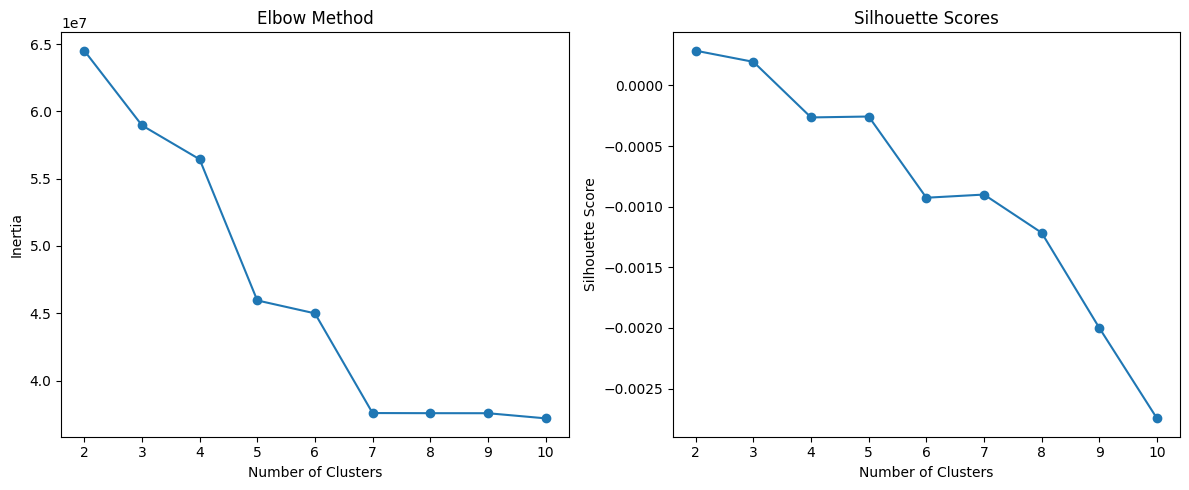

In [ ]:
# Plotting the Elbow Method
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plotting the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


# **Spectral Clustering**


In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from scipy.sparse import csgraph

In [ ]:
# Start with the original DataFrame
split_df = df.copy()

# Iterate over the specified columns
for column in ['Country', 'Genres']:
    # Split the values in the column by ', ' and then explode the lists into separate rows
    split_df = split_df.assign(**{column: split_df[column].str.split(', ')}).explode(column)

features = split_df[['Video_Type', 'Country', 'Year_Release', 'Rating', 'Genres']]
for column in features.columns:
    distinct_values = features[column].unique()
    print(distinct_values)

['Movie' 'TV Show']
['United States' 'South Africa' 'Unknown' 'India' 'United Kingdom'
 'Germany' 'Czech Republic' 'Mexico' 'Turkey' 'Australia' 'France'
 'Finland' 'China' 'Canada' 'Japan' 'Nigeria' 'Spain' 'Belgium'
 'South Korea' 'Singapore' 'Argentina' 'Venezuela' 'Hong Kong' 'Russia' ''
 'Ireland' 'Nepal' 'Italy' 'Brazil' 'Greece' 'Jordan' 'Colombia'
 'Switzerland' 'Israel' 'Taiwan' 'Bulgaria' 'Algeria' 'Poland'
 'New Zealand' 'Saudi Arabia' 'Thailand' 'Indonesia' 'Egypt' 'Denmark'
 'Kuwait' 'Netherlands' 'Malaysia' 'Vietnam' 'Sweden' 'Lebanon' 'Romania'
 'Syria' 'Philippines' 'Iceland' 'United Arab Emirates' 'Norway' 'Qatar'
 'Mauritius' 'Austria' 'Cameroon' 'Palestine' 'Uruguay' 'United Kingdom,'
 'Kenya' 'Chile' 'Luxembourg' 'Cambodia' 'Bangladesh' 'Portugal' 'Hungary'
 'Cayman Islands' 'Senegal' 'Serbia' 'Malta' 'Namibia' 'Angola' 'Peru'
 'Mozambique' 'Cambodia,' 'Belarus' 'Ghana' 'Zimbabwe' 'Puerto Rico'
 'Pakistan' 'Cyprus' 'Guatemala' 'Iraq' 'Malawi' 'Paraguay' 'Croatia'
 '

Here’s a breakdown of each feature, along with some sample categories:

* Video_Type: This column categorizes the content as either 'Movie' or 'TV Show'.

* Sample values: ['Movie', 'TV Show']
* Country: Represents the country where the content was produced. There are entries for various countries, and some values may contain multiple countries in a single row that are being split into separate rows.

* Sample values: ['United States', 'India', 'United Kingdom', 'Mexico', 'Turkey', etc.]
* Year_Release: This column contains the year in which the content was released, ranging from older releases (e.g., 2004) to more recent ones (e.g., 2021).

* Sample values: [2020, 2021, 2018, 2010, etc.]
* Rating: Represents the content's rating, indicating suitability for different audiences. Various rating systems like PG, R, and TV-MA are used.

* Sample values: ['PG-13', 'TV-MA', 'PG', 'TV-14', etc.]
* Genres: Contains the genres that describe the type of content, with each entry possibly containing multiple genres. After splitting the values, there'll be distinct genres per row.

* Sample values: ['Documentaries', 'TV Dramas', 'Crime TV Shows', 'Romantic Movies', etc.]*   

In [ ]:
# For Country
top_10_countries = features['Country'].value_counts().nlargest(10).index
features.loc[~features['Country'].isin(top_10_countries), 'Country'] = 'Others'

# For Genres
top_10_genres = features['Genres'].value_counts().nlargest(10).index
features.loc[~features['Genres'].isin(top_10_genres), 'Genres'] = 'Others'

for column in features.columns:
    distinct_values = features[column].unique()
    print(distinct_values)

['Movie' 'TV Show']
['United States' 'Others' 'Unknown' 'India' 'United Kingdom' 'Germany'
 'France' 'Canada' 'Japan' 'Spain' 'South Korea']
[2020 2021 2018 2010 2013 2017 2012 2014 2004 2011 2008 2009 2007 2005
 2006 2015 2019 2016]
['PG-13' 'TV-MA' 'PG' 'TV-14' 'TV-PG' 'TV-Y' 'TV-Y7' 'R' 'TV-G' 'G'
 'NC-17' 'NR' 'TV-Y7-FV' 'UR']
['Documentaries' 'International TV Shows' 'TV Dramas' 'Others'
 'Children & Family Movies' 'Comedies' 'Dramas' 'International Movies'
 'Thrillers' 'Independent Movies' 'Action & Adventure']


Since there are **numerous values** in both the Country and Genres columns, we'll identify the top ten most frequent values for each. All other values will be grouped and labeled as **"Others"** to simplify the next steps.

In [ ]:
# Encode categorical features as numerical values
label_encoders = {}
for column in features.columns:
    label_encoders[column] = LabelEncoder()
    features.loc[:, column] = label_encoders[column].fit_transform(features[column].astype(str))

This code snippet **encodes categorical features** in the features DataFrame into **numerical values** using LabelEncoder from sklearn.

In [ ]:
# Ensure the columns are integers
features = features.astype(int)
# Decode the label-encoded features
decoded_features = features.copy()
for column in decoded_features.columns:
    if column in label_encoders:
        decoded_features[column] = label_encoders[column].inverse_transform(features[column])

print("Decoded features:")
print(decoded_features)

Decoded features:
     Video_Type        Country Year_Release Rating                    Genres
0         Movie  United States         2020  PG-13             Documentaries
1       TV Show         Others         2021  TV-MA    International TV Shows
1       TV Show         Others         2021  TV-MA                 TV Dramas
1       TV Show         Others         2021  TV-MA                    Others
2       TV Show        Unknown         2021  TV-MA                    Others
...         ...            ...          ...    ...                       ...
8805      Movie  United States         2006     PG  Children & Family Movies
8805      Movie  United States         2006     PG                  Comedies
8806      Movie          India         2015  TV-14                    Dramas
8806      Movie          India         2015  TV-14      International Movies
8806      Movie          India         2015  TV-14                    Others

[21727 rows x 5 columns]


In [ ]:
print(features.dtypes)

Video_Type      int32
Country         int32
Year_Release    int32
Rating          int32
Genres          int32
dtype: object


In [ ]:
features = features.apply(pd.to_numeric, errors='coerce')  # Convert non-numeric to NaN

**Preprocessing** is performed to ensure the clustering process runs smoothly.

In [ ]:
for column in features.columns:
    distinct_values = features[column].unique()
    print(distinct_values)

[0 1]
[ 9  5 10  3  8  2  1  0  4  7  6]
[16 17 14  6  9 13  8 10  0  7  4  5  3  1  2 11 15 12]
[ 4  8  3  6  9 10 11  5  7  0  1  2 12 13]
[ 3  7  9  8  1  2  4  6 10  5  0]


**Random Sampling**

In [ ]:
# Random sampling (e.g., 10% of the dataset)
sample_fraction = 0.1  # Adjust this to choose your sample size
sampled_features = features.sample(frac=sample_fraction, random_state=42)

# Random sampling (e.g., 10% of the dataset)
sample_fraction = 0.1  # Adjust this to choose your sample size
decoded_sampled_features = decoded_features.sample(frac=sample_fraction, random_state=42)

This code snippet performs **random sampling** on the features DataFrame by **selecting 10%** of the data, as specified by the sample_fraction parameter.

**Random sampling is crucial in spectral clustering**, especially when dealing with **large datasets**. It helps manage computational complexity and reduces processing time by working with a smaller, representative subset of the data. This approach can make the clustering process more **efficient** and **manageable** without significantly compromising the quality of the results. Additionally, it can **prevent overfitting** and **improve the algorithm’s** performance by focusing on a diverse yet manageable sample of the data.

**Standard Scaler**

In [ ]:
# Standardize the data (important for PCA or distance-based calculations)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(sampled_features)
scaled_features

array([[-0.68428301,  1.00522854, -0.50830971, -2.6570866 ,  0.83329892],
       [-0.68428301,  1.00522854,  1.26954703, -2.11898323, -1.48323655],
       [-0.68428301, -1.14755886, -1.27024831, -0.50467311, -1.48323655],
       ...,
       [-0.68428301, -0.42996306, -2.03218691,  0.57153363,  0.06112043],
       [ 1.46138364, -0.42996306,  1.0155675 , -0.50467311,  0.83329892],
       [-0.68428301, -0.42996306,  1.0155675 ,  0.03343026,  0.06112043]])

This code snippet standardizes the sampled_features DataFrame using **StandardScaler** from sklearn. The StandardScaler object is initialized and then used to transform the data so that it has a **mean of 0 and a standard deviation of 1**.

Standardizing the data is essential for techniques like **Principal Component Analysis (PCA)** and distance-based calculations (such as clustering). It ensures that each feature **contributes equally to the analysis** by scaling all features to a common range. This prevents features with larger numerical ranges from disproportionately influencing the results and helps in achieving more accurate and meaningful clustering outcomes.

**Try first clustering using cosine similarity**

In [ ]:
# Compute the cosine similarity matrix on reduced data
similarity_matrix = cosine_similarity(scaled_features)

# Print the similarity matrix
print(similarity_matrix)

[[ 1.          0.542579    0.00876673 ... -0.05722612  0.01360295
  -0.12938188]
 [ 0.542579    1.          0.12838873 ... -0.54379875 -0.04771732
   0.28632275]
 [ 0.00876673  0.12838873  1.         ...  0.57833041 -0.55364457
  -0.13861969]
 ...
 [-0.05722612 -0.54379875  0.57833041 ...  1.         -0.66455147
  -0.47221514]
 [ 0.01360295 -0.04771732 -0.55364457 ... -0.66455147  1.
   0.09286005]
 [-0.12938188  0.28632275 -0.13861969 ... -0.47221514  0.09286005
   1.        ]]


In [ ]:
similarity_matrix = np.abs(similarity_matrix)  # Convert negatives to positive

In [ ]:
n_clusters =3  # Choose a suitable number of clusters
spectral_model = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
labels = spectral_model.fit_predict(similarity_matrix)

print(labels)  # Cluster labels for each data point

[1 0 2 ... 2 0 1]


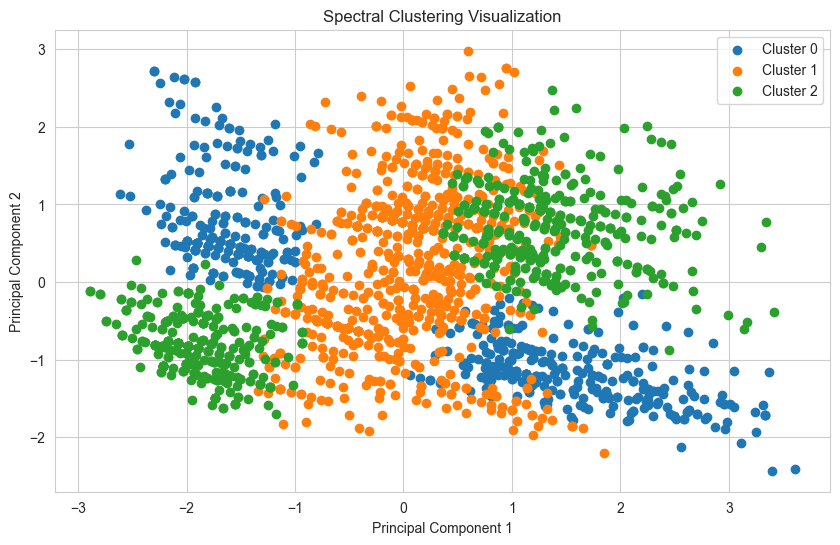

In [ ]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

# Plotting
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'Cluster {i}')

plt.title('Spectral Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

The spectral clustering results are unsuccessful. The clustering is generally good but could potentially be improve.

**Determination of n_clusters**

n_clusters=2, silhouette score=0.03741740590775648
n_clusters=3, silhouette score=0.06388539841861715
n_clusters=4, silhouette score=0.04554652978608625
n_clusters=5, silhouette score=0.03404190421398238


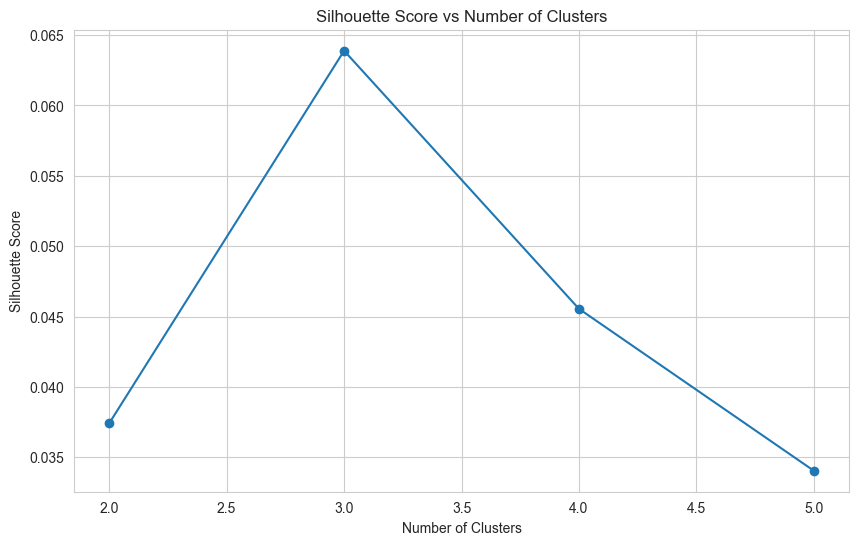

In [ ]:
# Function to calculate silhouette score for different cluster sizes
def evaluate_spectral_clustering(features, affinity_matrix, min_clusters=2, max_clusters=5):
    silhouette_scores = []
    for n_clusters in range(min_clusters, max_clusters + 1):
        spectral_model = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
        labels = spectral_model.fit_predict(affinity_matrix)
        score = silhouette_score(features, labels)  # Using original features
        silhouette_scores.append(score)
        print(f'n_clusters={n_clusters}, silhouette score={score}')
    return silhouette_scores

# Calculate silhouette scores for a range of clusters
min_clusters = 2
max_clusters = 5
silhouette_scores = evaluate_spectral_clustering(scaled_features, similarity_matrix, min_clusters, max_clusters)

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


According to the graph, the silhouette score is highest when the number of clusters is set to 3. Therefore, the following steps will be continue with **n_clusters = 3**.

### **Cosine**

In [ ]:
# Step 1: Compute the cosine similarity matrix
similarity_matrix_cosine = cosine_similarity(scaled_features)
similarity_matrix_cosine = np.abs(similarity_matrix_cosine)  # Convert negatives to positive
# Step 2: Apply Spectral Clustering with the cosine similarity matrix
n_clusters = 3
spectral_model_cs = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
labels_cs = spectral_model_cs.fit_predict(similarity_matrix_cosine)

# Print the cluster labels
print(labels_cs)  # Cluster labels for each data point

[1 2 0 ... 0 2 1]


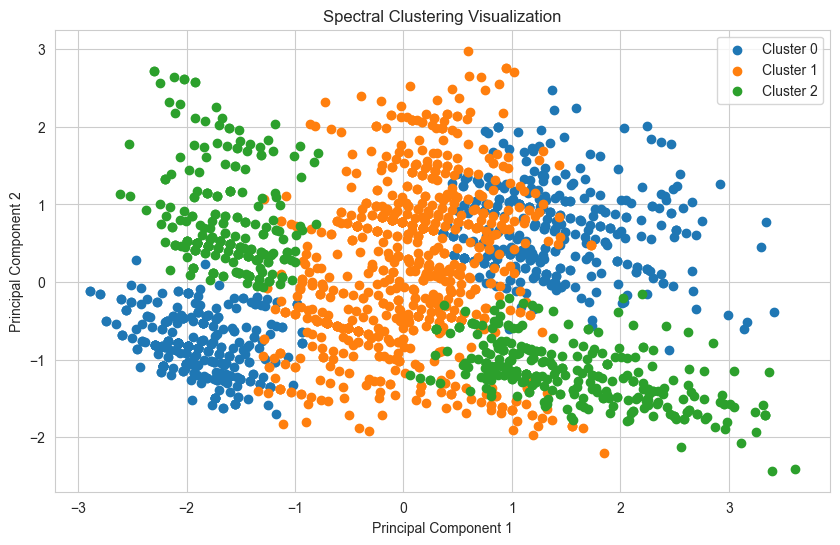

In [ ]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

# Plotting
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    plt.scatter(reduced_data[labels_cs == i, 0], reduced_data[labels_cs == i, 1], label=f'Cluster {i}')

plt.title('Spectral Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

Based on the grpah, the data points are grouped into three clusters, represented by different colors: blue (Cluster 0), orange (Cluster 1), and green (Cluster 2).



*   Cluster 0 (blue) appears to be more isolated on the left-hand side of the graph, suggesting a clear distinction from the other two clusters.

*   Cluster 1 (orange) is **located more centrally**, and some points overlap with both Cluster 0 and Cluster 2, **indicating possible ambiguity** in the clustering boundary.



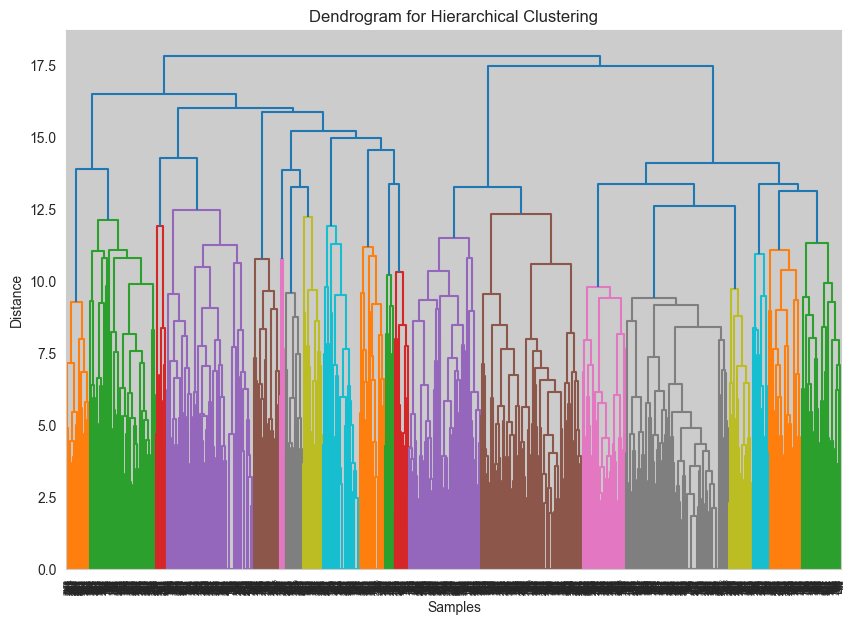

In [ ]:
# Convert cosine similarity matrix to a distance matrix (1 - similarity)
distance_matrix = 1 - similarity_matrix_cosine

# Perform hierarchical clustering using 'linkage'
linked = linkage(distance_matrix, method='average')

# Step 4: Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

### **RBF**

In [ ]:
# Step 1: Compute RBF kernel (affinity matrix)
gamma = 1.0  # control the width of the kernel
rbf_affinity_matrix = rbf_kernel(scaled_features, gamma=gamma)

# Step 2: Apply Spectral Clustering using RBF kernel
n_clusters
spectral_model = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
labels_rbf = spectral_model.fit_predict(rbf_affinity_matrix)

print(labels_rbf)

[1 0 0 ... 0 2 0]


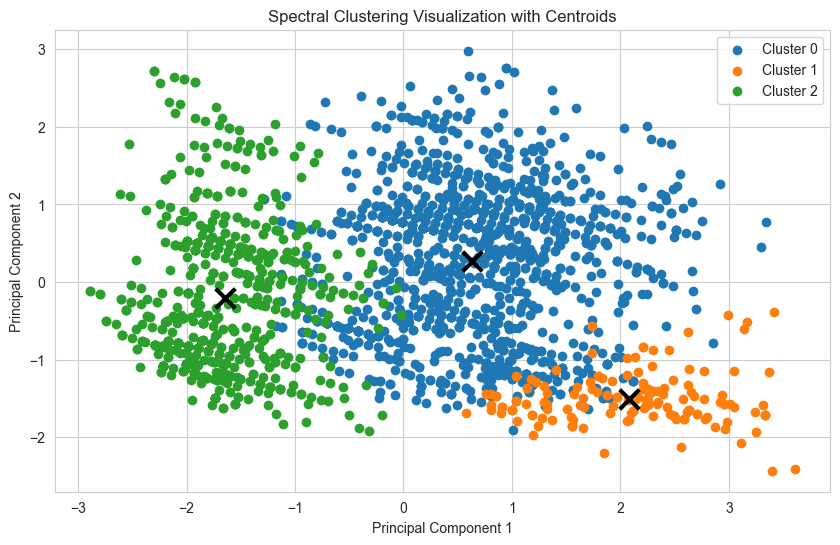

In [ ]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

# Plot the clusters
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    cluster_points = reduced_data[labels_rbf == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

    # Compute the centroid of each cluster and plot it as 'X'
    centroid = np.mean(cluster_points, axis=0)
    plt.scatter(centroid[0], centroid[1], color='black', marker='x', s=200, linewidths=3)

# Add titles and labels
plt.title('Spectral Clustering Visualization with Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

* There is a clear separation between Cluster 0 (blue) on the left and Cluster 2 (green) on the far right.
* Cluster 1 (orange) is in the middle, overlapping with both Cluster 0 and Cluster 2, indicating that these data points have similarities with both clusters.

In summary, this graph provides a visual representation of how spectral clustering has divided the data into three distinct clusters and indicates the central points (centroids) of each cluster.

C:\Users\user\AppData\Local\Temp\ipykernel_23700\1515449567.py:5: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



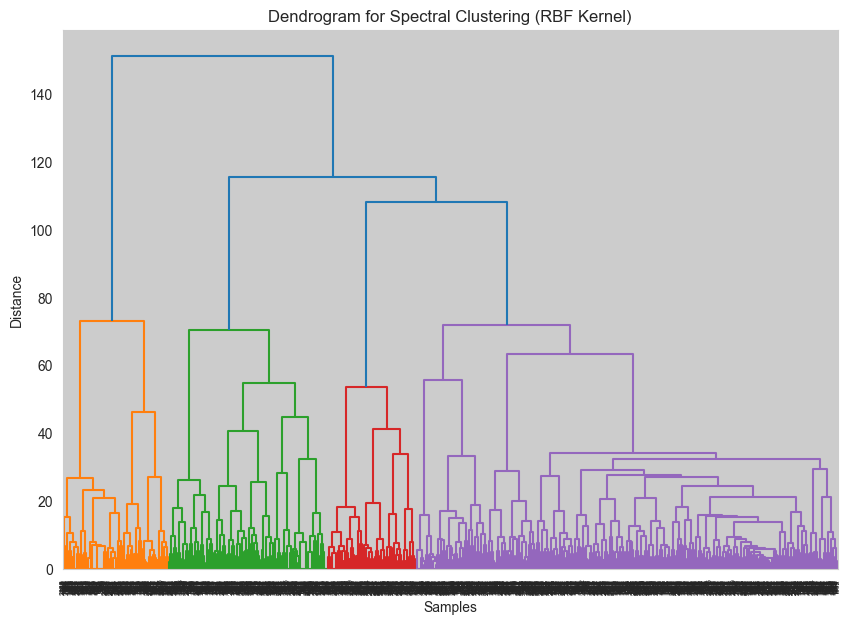

In [ ]:
# Step 2: Convert RBF similarity matrix to a distance matrix (1 - similarity)
distance_matrix_rbf = 1 - rbf_affinity_matrix

# Step 3: Perform hierarchical clustering using 'linkage'
linked_rbf = linkage(distance_matrix_rbf, method='ward')  # Can also use 'average', 'complete', etc.

# Step 4: Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked_rbf)
plt.title('Dendrogram for Spectral Clustering (RBF Kernel)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

### **Kneighbors_graph**

In [ ]:
from sklearn.neighbors import kneighbors_graph
# Compute the k-nearest neighbors graph
n_neighbors = 40
knn_graph = kneighbors_graph(scaled_features, n_neighbors=n_neighbors, mode='connectivity', include_self=False)

# Symmetrize the affinity matrix again
affinity_matrix = 0.5 * (knn_graph.toarray() + knn_graph.toarray().T)

spectral_model_nn = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
labels_nn = spectral_model_nn.fit_predict(affinity_matrix)

print(labels_nn)

[2 2 0 ... 0 1 0]


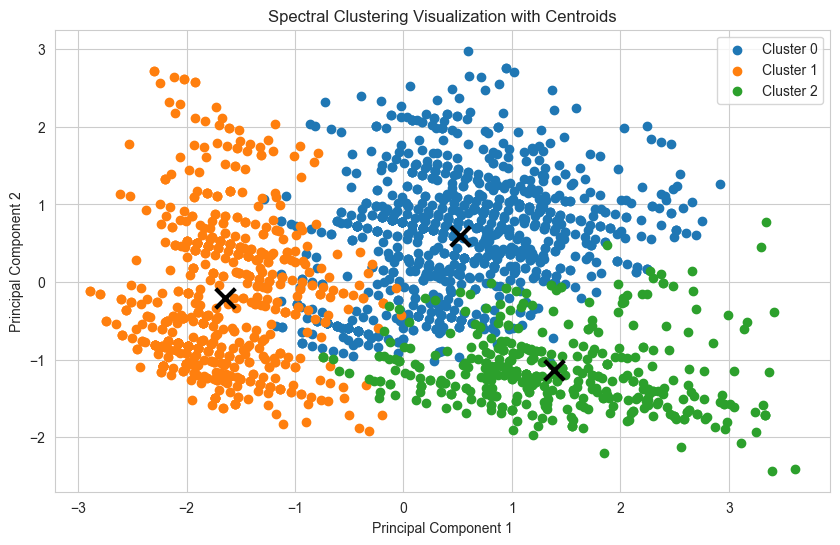

In [ ]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

# Plot the clusters
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    cluster_points = reduced_data[labels_nn == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

    # Compute the centroid of each cluster and plot it as 'X'
    centroid = np.mean(cluster_points, axis=0)
    plt.scatter(centroid[0], centroid[1], color='black', marker='x', s=200, linewidths=3)

# Add titles and labels
plt.title('Spectral Clustering Visualization with Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

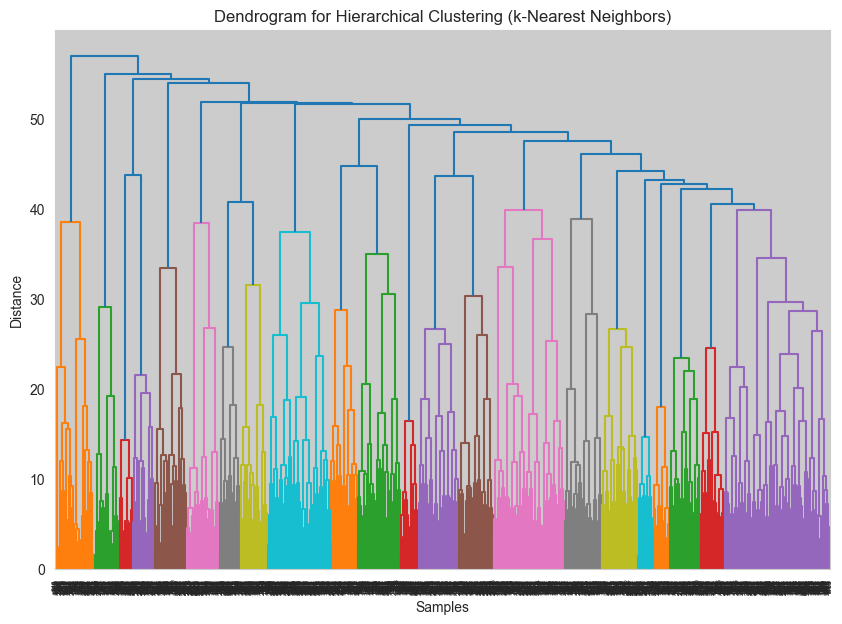

In [ ]:
distance_matrix_knn = 1 - affinity_matrix

# Step 4: Perform hierarchical clustering using 'linkage'
linked_knn = linkage(distance_matrix_knn, method='ward')  # Can use 'complete', 'average', etc.

# Step 5: Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked_knn)
plt.title('Dendrogram for Hierarchical Clustering (k-Nearest Neighbors)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


# List of label sets to evaluate
label_sets = [labels_cs, labels_rbf, labels_nn]
label_names = ['Original(Precomputed using cosine)', 'RBF Kernel', 'Nearest Neighbors']

for labels, name in zip(label_sets, label_names):
    silhouette_avg = silhouette_score(scaled_features, labels)
    db_index = davies_bouldin_score(scaled_features, labels)
    ch_index = calinski_harabasz_score(scaled_features, labels)

    print(f'Clustering Method: {name}')
    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Score: {db_index}')
    print(f'Calinski-Harabasz Index: {ch_index}\n')

Clustering Method: Original(Precomputed using cosine)
Silhouette Score: 0.0637267498945863
Davies-Bouldin Score: 7.437904883133254
Calinski-Harabasz Index: 51.84766798014199

Clustering Method: RBF Kernel
Silhouette Score: 0.2724571925474304
Davies-Bouldin Score: 1.2681917147035031
Calinski-Harabasz Index: 649.3933826946321

Clustering Method: Nearest Neighbors
Silhouette Score: 0.28421253997995016
Davies-Bouldin Score: 1.5125072850664598
Calinski-Harabasz Index: 749.4031269077273





*   **Silhouette Score**, higher is better as it indicates how similar points in the same cluster are, compared to points in other clusters.
*  **Davies-Bouldin Index (DBI)**, lower is better as it indicates how well-separated and compact the clusters are.
*   **Calinski-Harabasz Index (CH Index)**, higher is better as it measures the ratio of the sum of between-cluster dispersion and within-cluster dispersion.

*    **Nearest Neighbors clustering** shows the best overall performance when considering all three metrics, with the lower DBI (1.51), highest Calinski-Harabasz Index (748.89) and highest Silhouette Score (0.28).



### **Graph Regularization**



*   Normalized Laplacian (L_sym)



In [ ]:
n_neighbors = 40  # Define the number of neighbors
n_clusters = 3    # Define number of clusters

# Compute the k-nearest neighbors graph (affinity matrix)
knn_graph = kneighbors_graph(scaled_features, n_neighbors=n_neighbors, mode='connectivity', include_self=False)
affinity_matrix = knn_graph.toarray()

# Compute the normalized Laplacian (L_sym)
laplacian_matrix = csgraph.laplacian(affinity_matrix, normed=True)

# If negative values are a concern, make all values positive (if applicable)
laplacian_matrix = np.abs(laplacian_matrix)  # Convert negatives to positive

# Ensure the affinity matrix is symmetric by averaging it with its transpose
laplacian_matrix_symmetric = (laplacian_matrix + laplacian_matrix.T) / 2

In [ ]:
spectral_model = SpectralClustering(n_clusters= n_clusters , affinity='precomputed')
labels_sym = spectral_model.fit_predict(laplacian_matrix_symmetric)
print(labels_sym)

[1 1 1 ... 0 2 0]


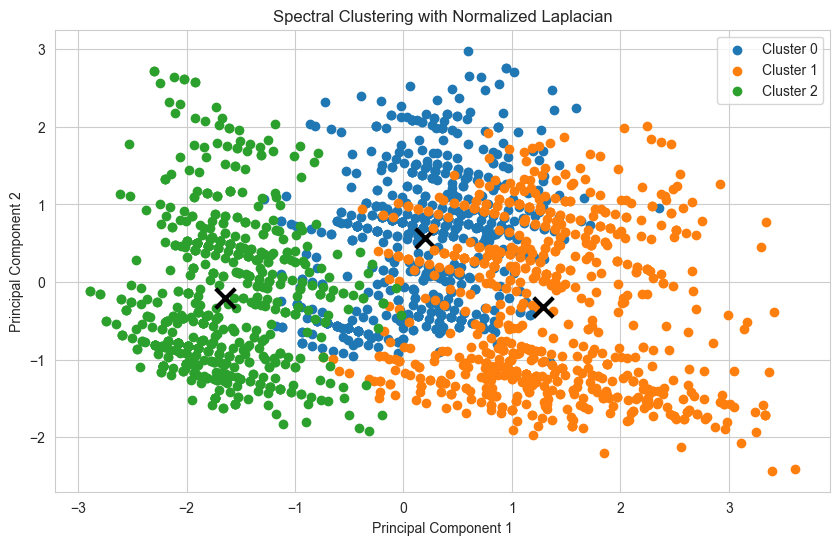

In [ ]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

# Plot the clusters
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    cluster_points = reduced_data[labels_sym == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

    # Compute the centroid of each cluster and plot it as 'X'
    centroid = np.mean(cluster_points, axis=0)
    plt.scatter(centroid[0], centroid[1], color='black', marker='x', s=200, linewidths=3)

plt.title('Spectral Clustering with Normalized Laplacian')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

*   Unnormalized Laplacian

In [ ]:
# Unnormalized Laplacian
unnormalized_laplacian = csgraph.laplacian(affinity_matrix, normed=False)

# If negative values are a concern, make all values positive (if applicable)
unnormalized_laplacian = np.abs(unnormalized_laplacian)  # Convert negatives to positive

# Ensure the affinity matrix is symmetric by averaging it with its transpose
unnormalized_laplacian_symmetric = (unnormalized_laplacian + unnormalized_laplacian.T) / 2

spectral_model_sym = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
labels_un = spectral_model_sym.fit_predict(unnormalized_laplacian_symmetric)

print(labels_un)

[0 0 1 ... 1 2 1]


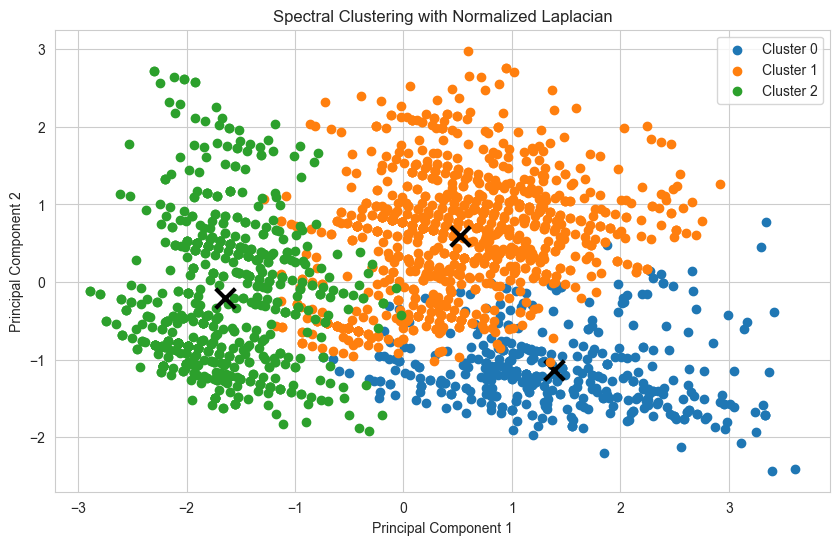

In [ ]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

# Plot the clusters
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    cluster_points = reduced_data[labels_un == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

    # Compute the centroid of each cluster and plot it as 'X'
    centroid = np.mean(cluster_points, axis=0)
    plt.scatter(centroid[0], centroid[1], color='black', marker='x', s=200, linewidths=3)

plt.title('Spectral Clustering with Normalized Laplacian')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [ ]:
# Define a function to compute clustering metrics
def evaluate_clustering(labels, data):
    silhouette_avg = silhouette_score(data, labels)
    db_index = davies_bouldin_score(data, labels)
    ch_index = calinski_harabasz_score(data, labels)
    return silhouette_avg, db_index, ch_index

# Evaluate each Laplacian version
metrics_un = evaluate_clustering(labels_un, scaled_features)
metrics_sym = evaluate_clustering(labels_sym, scaled_features)

print("Unnormalized Laplacian metrics:")
print(f"Silhouette Score: {metrics_un[0]}")
print(f"Davies-Bouldin Index: {metrics_un[1]}")
print(f"Calinski-Harabasz Index: {metrics_un[2]}")

print("\nSymmetric Normalized Laplacian metrics:")
print(f"Silhouette Score: {metrics_sym[0]}")
print(f"Davies-Bouldin Index: {metrics_sym[1]}")
print(f"Calinski-Harabasz Index: {metrics_sym[2]}")

Unnormalized Laplacian metrics:
Silhouette Score: 0.28421253997995016
Davies-Bouldin Index: 1.5125072850664598
Calinski-Harabasz Index: 749.4031269077271

Symmetric Normalized Laplacian metrics:
Silhouette Score: 0.2620519505882479
Davies-Bouldin Index: 1.6066029197544731
Calinski-Harabasz Index: 753.6852156440964


The **Unnormalized Laplacian** appears to be **slightly better overall**, based on the higher Silhouette Score and lower Davies-Bouldin Index, which are generally considered more important for measuring the quality of clustering.




In [ ]:
feature_df = pd.DataFrame(decoded_sampled_features, columns=['Video_Type', 'Country', 'Year_Release', 'Rating', 'Genres'])

In [ ]:
feature_df['Cluster'] = labels_un

In [ ]:
print(feature_df)

     Video_Type        Country Year_Release Rating                Genres  \
8096      Movie  United States         2014     NR                Others   
1218      Movie  United States         2021     PG              Comedies   
4736      Movie          India         2011  TV-14              Comedies   
2726      Movie          India         2014  TV-14                Dramas   
277     TV Show         Others         2021  TV-14                Others   
...         ...            ...          ...    ...                   ...   
3125      Movie        Germany         2015      R                Dramas   
6233      Movie         Others         2017  TV-MA         Documentaries   
2614      Movie         Others         2008  TV-MA  International Movies   
1658    TV Show         Others         2020  TV-14                Others   
2057      Movie         Others         2020   TV-G  International Movies   

      Cluster  
8096        0  
1218        0  
4736        1  
2726        1  
277    

In [ ]:
feature_df.dtypes

Video_Type      object
Country         object
Year_Release    object
Rating          object
Genres          object
Cluster          int32
dtype: object

In [ ]:
# Separate categorical and numerical columns
categorical_columns = ['Video_Type', 'Country', 'Rating', 'Genres']
numerical_columns = ['Year_Release']

# Aggregate categorical features
categorical_summary = feature_df.groupby('Cluster').agg({
    'Video_Type': lambda x: x.mode()[0],
    'Country': lambda x: x.mode()[0],
    'Year_Release': lambda x:x.mode()[0],
    'Rating': lambda x: x.mode()[0],
    'Genres': lambda x: x.mode()[0]
}).reset_index()

print(categorical_summary)

   Cluster Video_Type        Country Year_Release Rating                Genres
0        0      Movie  United States         2017      R                Dramas
1        1      Movie         Others         2018  TV-MA  International Movies
2        2    TV Show  United States         2020  TV-MA                Others


* Cluster 0: Contains movies from various countries with a focus on international films and mature content, primarily from around 2018.
* Cluster 1: Features U.S. TV shows released around 2020 with a variety of genres and mature content.
* Cluster 2: Contains U.S. movies, particularly dramas, with restricted content from around 2017.

# **K-Prototypes**

In [ ]:
import pandas as pd
import numpy as np
from kmodes.kprototypes import KPrototypes

In [ ]:
# 1. Process Duration
def process_duration(row):
    duration = row['Duration']
    if row['Video_Type'] == 'Movie':
        # Extract minutes from '90 min' format
        return int(duration.split()[0])
    else:
        # Extract seasons from '3 Seasons' format
        return int(duration.split()[0])

In [ ]:
# 2. Process Genres and Countries
def get_dummies_from_list_column(df, column_name, separator=','):
    # Split the strings and explode into separate rows
    expanded = df[column_name].str.split(separator).explode()
    # Remove leading/trailing whitespace
    expanded = expanded.str.strip()
    # Create dummies and sum them up for each original row
    dummies = pd.get_dummies(expanded, prefix=column_name)
    dummies = dummies.groupby(level=0).sum()
    return dummies

In [ ]:
# Create separate duration columns for movies and TV shows
df['Movie_Duration'] = df.apply(
    lambda x: process_duration(x) if x['Video_Type'] == 'Movie' else 0,
    axis=1
)
df['TV_Seasons'] = df.apply(
    lambda x: process_duration(x) if x['Video_Type'] == 'TV Show' else 0,
    axis=1
)

In [ ]:
df.head()

Show_ID Video_Type                  Title         Director  \
0      s1      Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2    TV Show          Blood & Water          Unknown   
2      s3    TV Show              Ganglands  Julien Leclercq   
3      s4    TV Show  Jailbirds New Orleans          Unknown   
4      s5    TV Show           Kota Factory          Unknown   

                                                Cast        Country  \
0                                            Unknown  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...        Unknown   
3                                            Unknown        Unknown   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

  Date_Added  Year_Release Rating   Duration  \
0 2021-09-25          2020  PG-13     90 min   
1 2021-09-24          2021  TV-MA  2 Seasons   
2 2021-09-24          2021  TV-MA   1 Season   
3 2021-09-24          2021  TV-MA   1 Season   
4 2021-09-24          2021  TV-MA  2 Seasons   

                                              Genres  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         Description  Movie_Duration  \
0  As her father nears the end of his life, filmm...              90   
1  After crossing paths at a party, a Cape Town t...               0   
2  To protect his family from a powerful drug lor...               0   
3  Feuds, flirtations and toilet talk go down amo...               0   
4  In a city of coaching centers known to train I...               0   

   TV_Seasons  
0           0  
1           2  
2           1  
3           1  
4           2

In [ ]:
# Get dummy variables for Genres and Countries
genres_dummies = get_dummies_from_list_column(df, 'Genres')
country_dummies = get_dummies_from_list_column(df, 'Country')

# To avoid too many features, we might want to keep only the most common ones
top_genres = genres_dummies.sum().nlargest(10).index
top_countries = country_dummies.sum().nlargest(15).index

genres_dummies = genres_dummies[top_genres]
country_dummies = country_dummies[top_countries]

In [ ]:
print(genres_dummies)
print(country_dummies)

      Genres_International Movies  Genres_Dramas  Genres_Comedies  \
0                               0              0                0   
1                               0              0                0   
2                               0              0                0   
3                               0              0                0   
4                               0              0                0   
...                           ...            ...              ...   
8802                            0              1                0   
8803                            0              0                0   
8804                            0              0                1   
8805                            0              0                1   
8806                            1              1                0   

      Genres_International TV Shows  Genres_Documentaries  \
0                                 0                     1   
1                                 1              

In [ ]:
# Prepare final feature set
numerical_features = ['Year_Release', 'Movie_Duration', 'TV_Seasons']
numerical_data = df[numerical_features].values

# Convert Video_Type and Rating to dummy variables
categorical_data = pd.get_dummies(df['Video_Type'])
categorical_data = pd.concat([
    categorical_data,
    pd.get_dummies(df['Rating']),
    genres_dummies,
    country_dummies
], axis=1)

In [ ]:
# Combine numerical and categorical data
X = np.hstack((numerical_data, categorical_data.values))

# Mark categorical columns
categorical_features_idx = list(range(len(numerical_features), X.shape[1]))

In [ ]:
# Perform clustering
n_clusters = 5
kproto = KPrototypes(n_clusters=n_clusters, random_state=42)
clusters = kproto.fit_predict(X, categorical=categorical_features_idx)

In [ ]:
# Add cluster labels to the original dataframe
df['Cluster'] = clusters

# Analyze results
print("\nCluster sizes:")
print(df['Cluster'].value_counts())

# Examine cluster characteristics
for cluster in range(n_clusters):
    print(f"\nCluster {cluster} characteristics:")
    cluster_data = df[df['Cluster'] == cluster]

    # Numerical features summary
    print("\nNumerical features:")
    print(cluster_data[numerical_features].mean())

    # Video Type distribution
    print("\nVideo Type distribution:")
    print(cluster_data['Video_Type'].value_counts(normalize=True))

    # Top 5 genres in this cluster
    print("\nTop 5 genres:")
    # Modified this part to use boolean indexing
    mask = df['Cluster'] == cluster
    cluster_genres = genres_dummies[mask]
    print(cluster_genres.sum().nlargest(5))

    # Top 5 countries in this cluster
    print("\nTop 5 countries:")
    cluster_countries = country_dummies[mask]
    print(cluster_countries.sum().nlargest(5))


Cluster sizes:
Cluster
1    3040
0    2806
4    1716
3     839
2     406
Name: count, dtype: int64

Cluster 0 characteristics:

Numerical features:
Year_Release      2016.574127
Movie_Duration       1.047398
TV_Seasons           1.683179
dtype: float64

Video Type distribution:
Video_Type
TV Show    0.953671
Movie      0.046329
Name: proportion, dtype: float64

Top 5 genres:
Genres_International TV Shows      1351
Genres_TV Dramas                    763
Genres_Children & Family Movies      62
Genres_Documentaries                 31
Genres_International Movies          20
dtype: int64

Top 5 countries:
Country_United States     1001
Country_Unknown            423
Country_United Kingdom     280
Country_Japan              203
Country_South Korea        171
dtype: int64

Cluster 1 characteristics:

Numerical features:
Year_Release      2013.931579
Movie_Duration      93.865461
TV_Seasons           0.000000
dtype: float64

Video Type distribution:
Video_Type
Movie    1.0
Name: proportion, 

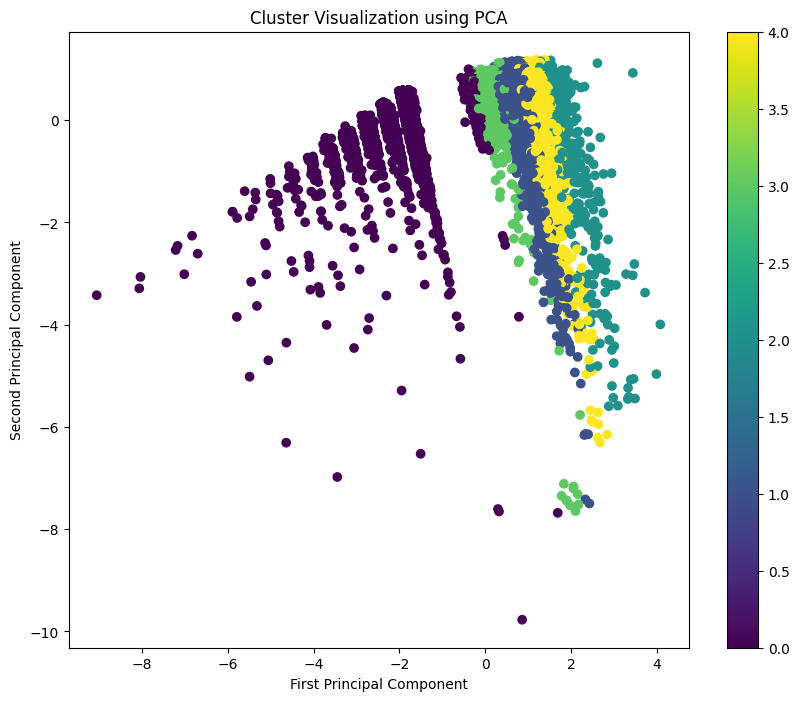

In [ ]:
# PCA or t-SNE visualization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Standardize numerical features
scaler = StandardScaler()
X_scaled = np.copy(X)
X_scaled[:, :len(numerical_features)] = scaler.fit_transform(X[:, :len(numerical_features)])

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Cluster Visualization using PCA')
plt.colorbar(scatter)
plt.show()

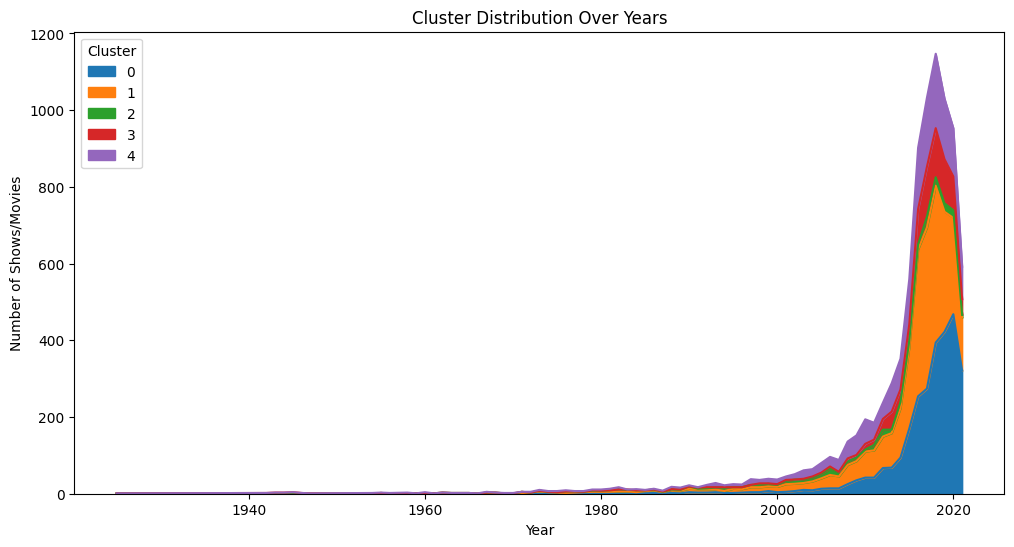

In [ ]:
# Analyze how clusters change over time
yearly_distribution = df.groupby(['Year_Release', 'Cluster']).size().unstack()
yearly_distribution.plot(kind='area', stacked=True, figsize=(12, 6))
plt.title('Cluster Distribution Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Shows/Movies')
plt.show()

In [ ]:
from scipy import stats

# Compare numerical features across clusters
for feature in numerical_features:
    print(f"\nAnalysis of {feature} across clusters:")
    # ANOVA test
    cluster_groups = [df[df['Cluster'] == i][feature] for i in range(n_clusters)]
    f_stat, p_value = stats.f_oneway(*cluster_groups)
    print(f"ANOVA test: F-statistic = {f_stat:.2f}, p-value = {p_value:.4f}")


Analysis of Year_Release across clusters:
ANOVA test: F-statistic = 207.97, p-value = 0.0000

Analysis of Movie_Duration across clusters:
ANOVA test: F-statistic = 75415.51, p-value = 0.0000

Analysis of TV_Seasons across clusters:
ANOVA test: F-statistic = 1681.83, p-value = 0.0000


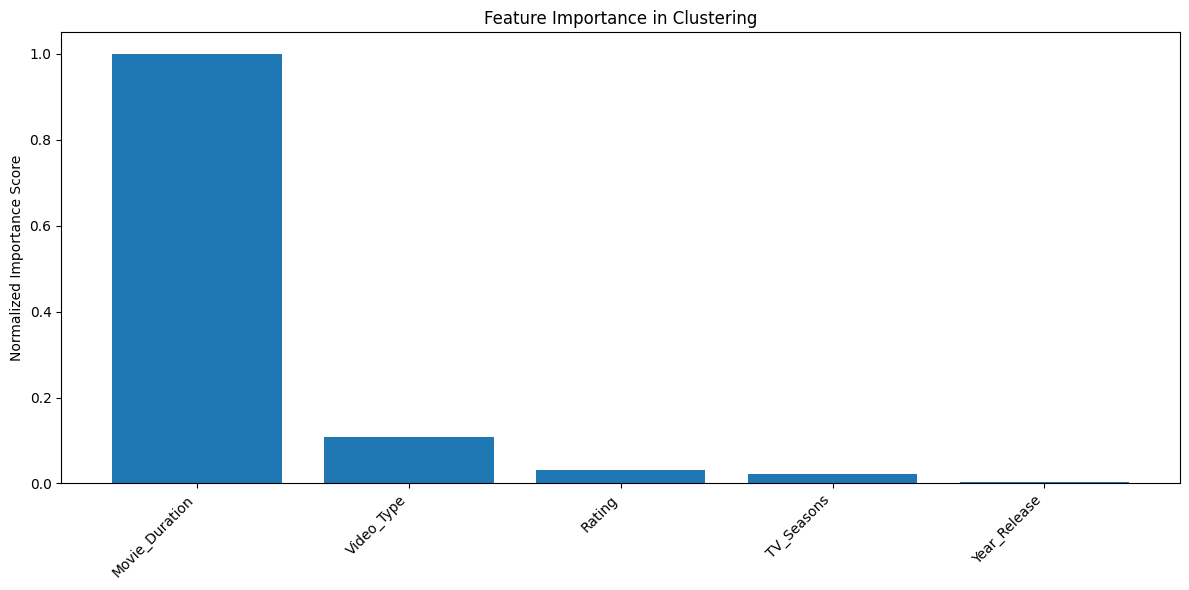

Movie_Duration: 1.0000
Video_Type: 0.1090
Rating: 0.0310
TV_Seasons: 0.0223
Year_Release: 0.0028


In [ ]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_feature_importance(df, n_clusters, features):
    """
    Analyze feature importance in clustering using F-statistic for numerical features
    and Chi-square for categorical features.
    """
    importance_dict = {}
    
    for feature in features:
        try:
            if pd.api.types.is_numeric_dtype(df[feature]):
                # Calculate F-statistic for numerical features
                f_stat, _ = stats.f_oneway(*[df[df['Cluster'] == i][feature].dropna() 
                                           for i in range(n_clusters)])
                importance_dict[feature] = f_stat
            else:
                # Calculate Chi-square for categorical features
                contingency_table = pd.crosstab(df['Cluster'], df[feature])
                chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)
                importance_dict[feature] = chi2_stat
        except Exception as e:
            print(f"Warning: Could not calculate importance for {feature}. Error: {str(e)}")
            importance_dict[feature] = 0
    
    # Normalize values between 0 and 1
    if importance_dict:
        max_value = max(importance_dict.values())
        if max_value > 0:  # Avoid division by zero
            importance_dict = {k: v/max_value for k, v in importance_dict.items()}
    
    # Sort features by importance
    return dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

# Define features
numerical_features = ['Year_Release', 'Movie_Duration', 'TV_Seasons']  # Adjust based on your actual numerical features
categorical_features = ['Video_Type', 'Rating']
features_to_analyze = numerical_features + categorical_features

# Calculate feature importance
importance_scores = analyze_feature_importance(df, n_clusters=5, features=features_to_analyze)  # Adjust n_clusters as needed

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.bar(importance_scores.keys(), importance_scores.values())
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance in Clustering')
plt.ylabel('Normalized Importance Score')
plt.tight_layout()
plt.show()

# Print importance scores
for feature, score in importance_scores.items():
    print(f"{feature}: {score:.4f}")

In [ ]:
def create_cluster_profile(df, cluster_id):
    cluster_data = df[df['Cluster'] == cluster_id]
    
    profile = {
        'size': len(cluster_data),
        'percentage': len(cluster_data) / len(df) * 100,
        'avg_year': cluster_data['Year_Release'].mean(),
        'dominant_type': cluster_data['Video_Type'].mode()[0],
        'top_ratings': cluster_data['Rating'].value_counts().head(3).to_dict(),
        'avg_movie_duration': cluster_data['Movie_Duration'].mean(),
        'avg_tv_seasons': cluster_data['TV_Seasons'].mean()
    }
    
    return profile

# Create profiles for all clusters
cluster_profiles = {i: create_cluster_profile(df, i) for i in range(n_clusters)}

# Print detailed profiles
for cluster_id, profile in cluster_profiles.items():
    print(f"\nCluster {cluster_id} Profile:")
    for key, value in profile.items():
        print(f"{key}: {value}")


Cluster 0 Profile:
size: 2806
percentage: 31.861019643465426
avg_year: 2016.5741268709908
dominant_type: TV Show
top_ratings: {'TV-MA': 1161, 'TV-14': 745, 'TV-PG': 347}
avg_movie_duration: 1.0473984319315752
avg_tv_seasons: 1.6831789023521027

Cluster 1 Profile:
size: 3040
percentage: 34.517997047802886
avg_year: 2013.9315789473685
dominant_type: Movie
top_ratings: {'TV-MA': 1119, 'TV-14': 564, 'R': 459}
avg_movie_duration: 93.86546052631579
avg_tv_seasons: 0.0

Cluster 2 Profile:
size: 406
percentage: 4.609969342568411
avg_year: 2004.4950738916257
dominant_type: Movie
top_ratings: {'TV-14': 211, 'TV-MA': 73, 'TV-PG': 44}
avg_movie_duration: 159.8694581280788
avg_tv_seasons: 0.0

Cluster 3 Profile:
size: 839
percentage: 9.526513001021915
avg_year: 2014.9809296781884
dominant_type: Movie
top_ratings: {'TV-MA': 370, 'TV-14': 129, 'TV-PG': 116}
avg_movie_duration: 61.08700834326579
avg_tv_seasons: 0.0

Cluster 4 Profile:
size: 1716
percentage: 19.484500965141365
avg_year: 2012.606060606

Training model with k=1...
Training model with k=2...
Training model with k=3...
Training model with k=4...
Training model with k=5...
Training model with k=6...
Training model with k=7...
Training model with k=8...
Training model with k=9...


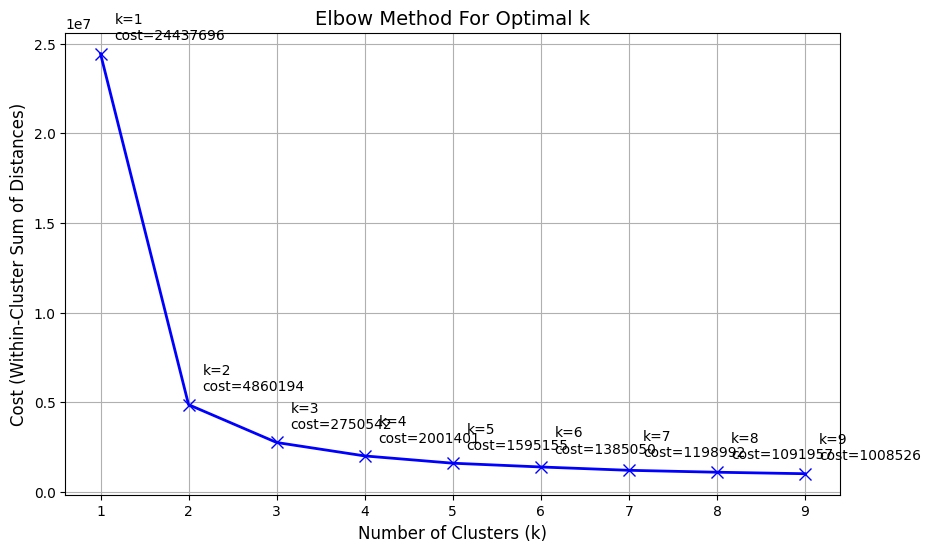

k=1: cost=24437696.68964155
k=2: cost=4860194.982262535
k=3: cost=2750542.5015826053
k=4: cost=2001401.3454331676
k=5: cost=1595155.3418268668
k=6: cost=1385050.8773000753
k=7: cost=1198992.0087586814
k=8: cost=1091957.2969961623
k=9: cost=1008526.7077680301


In [ ]:
import matplotlib.pyplot as plt

# Elbow method
cost = []
K = range(1, 10)

for k in K:
    print(f"Training model with k={k}...")  # Progress indicator
    kproto = KPrototypes(n_clusters=k, random_state=42)
    kproto.fit_predict(X, categorical=categorical_features_idx)
    cost.append(kproto.cost_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, cost, 'bx-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Cost (Within-Cluster Sum of Distances)', fontsize=12)
plt.title('Elbow Method For Optimal k', fontsize=14)
plt.grid(True)

# Add annotations for each point
for i, c in enumerate(cost):
    plt.annotate(f'k={K[i]}\ncost={int(c)}',
                xy=(K[i], c),
                xytext=(10, 10),
                textcoords='offset points')

plt.show()

# Print the costs
for i, c in enumerate(cost):
    print(f'k={K[i]}: cost={c}')